In [510]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [511]:
from datetime import datetime, timedelta

def get_first_sunday_of_november(year):
    """Gets the first Sunday of November for a given year."""
    date = datetime(year, 11, 1)
    while date.weekday() != 6:  # 6 represents Sunday
        date += timedelta(days=1)
    return date

def get_second_sunday_of_october(year):
    """
    Gets the second Sunday of October for a given year unless the first Sunday 
    is October 7, in which case it returns the first Sunday.
    """
    date = datetime(year, 10, 1)
    count = 0

    while count < 2:
        if date.weekday() == 6:  # Sunday
            count += 1
            if count == 1 and date.day == 7:  # Special case: first Sunday is October 7
                return date
        if count < 2:
            date += timedelta(days=1)
    
    return date

def get_third_monday_in_april(year):
    """Gets the third Monday in April for a given year."""
    date = datetime(year, 4, 1)
    count = 0
    while count < 3:
        if date.weekday() == 0:  # Monday
            count += 1
        if count < 3:
            date += timedelta(days=1)
    return date

def get_third_sunday_in_march(year):
    """Gets the third Sunday in March for a given year."""
    date = datetime(year, 3, 1)
    count = 0
    while count < 3:
        if date.weekday() == 6:  # Sunday
            count += 1
        if count < 3:
            date += timedelta(days=1)
    return date

def get_second_sunday_in_december(year):
    """Gets the second Sunday in December for a given year."""
    date = datetime(year, 12, 1)
    count = 0
    while count < 2:
        if date.weekday() == 6:  # Sunday
            count += 1
        if count < 2:
            date += timedelta(days=1)
    return date

def get_last_sunday_in_october(year):
    """Gets the last Sunday in October for a given year."""
    date = datetime(year, 10, 31)
    while date.weekday() != 6:  # Sunday
        date -= timedelta(days=1)
    return date

def get_second_sunday_in_january(year):
    """Gets the second Sunday in January, unless the first Sunday is January 7, then returns the first Sunday."""
    date = datetime(year, 1, 1)
    count = 0
    while count < 2:
        if date.weekday() == 6:  # Sunday
            count += 1
            if count == 1 and date.day == 7:  # Special case
                return date
        if count < 2:
            date += timedelta(days=1)
    return date

def get_sunday_before_thanksgiving(year):
    """
    Gets the Sunday before Thanksgiving for a given year.
    Thanksgiving is on the fourth Thursday of November.
    """
    # Find the fourth Thursday of November
    thanksgiving = datetime(year, 11, 1)
    thursday_count = 0

    while thursday_count < 4:
        if thanksgiving.weekday() == 3:  # Thursday
            thursday_count += 1
        if thursday_count < 4:
            thanksgiving += timedelta(days=1)

    # Calculate the Sunday before Thanksgiving
    sunday_before = thanksgiving - timedelta(days=4)  # Go back 4 days to the previous Sunday
    return sunday_before


def get_first_or_second_sunday_in_december(year):
    """
    Gets the first Sunday in December unless December 1 is a Sunday,
    in which case it returns the second Sunday.
    """
    date = datetime(year, 12, 1)
    
    # Check if December 1st is a Sunday
    if date.weekday() == 6:  # If December 1 is a Sunday
        date += timedelta(days=7)  # Move to the second Sunday
    else:
        # Otherwise, find the first Sunday
        days_to_sunday = (6 - date.weekday()) % 7
        date += timedelta(days=days_to_sunday)
    
    return date

def get_saturday_of_third_full_weekend_in_june(year):
    """
    Gets the Saturday of the third full weekend in June (weekend defined as Friday-Saturday-Sunday).
    """
    date = datetime(year, 6, 1)
    count = 0
    while count < 3:
        if date.weekday() == 4:  # Friday
            # Check if it's a full weekend (Friday-Saturday-Sunday)
            if (date + timedelta(days=1)).month == 6 and (date + timedelta(days=2)).month == 6:
                count += 1
        if count < 3:
            date += timedelta(days=1)
    
    return date + timedelta(days=1)


def get_third_sunday_in_january(year):
    """Gets the third Sunday in January unless the first Sunday is January 7, then returns the second Sunday."""
    # Start from January 1st
    date = datetime(year, 1, 1)
    
    # Adjust date to the first Sunday in January
    while date.weekday() != 6:  # 6 corresponds to Sunday
        date += timedelta(days=1)

    # If the first Sunday is January 7, return the second Sunday
    if date.day == 7:
        return date + timedelta(days=7)  # Move to the second Sunday
    
    # Otherwise, return the third Sunday
    return date + timedelta(weeks=2)


In [512]:
import numpy as np
from timezonefinder import TimezoneFinder
import pandas as pd
from meteostat import Point, Hourly

def get_timezone(lat, long):
    tf = TimezoneFinder()
    return tf.timezone_at(lng=long, lat=lat)

def convert_utc_to_timezone(df, utc_column, lat, long):
    timezone = get_timezone(lat, long)
    df = df.copy()  # Ensure we're working with a copy to avoid the SettingWithCopyWarning
    df[utc_column] = pd.to_datetime(df[utc_column], utc=True)
    df['local_datetime'] = df[utc_column].dt.tz_convert(timezone)
    df['local_date'] = df['local_datetime'].dt.date
    df['local_time'] = df['local_datetime'].dt.time
    return df

def celsius_to_fahrenheit(celsius):
    """
    Converts a temperature from Celsius to Fahrenheit.
    
    Parameters:
    - celsius (float or int): Temperature in Celsius.
    
    Returns:
    - float: Temperature in Fahrenheit.
    """
    return (celsius * 9/5) + 32

def get_marathon_weather_data(latitude, longitude, race_time, date_list, marathon_name):
    location = Point(latitude, longitude)
    all_data = []
    
    for day in date_list:
        data = Hourly(location, day, day + timedelta(days=1))
        data = data.fetch()
        
        # Reset index and ensure we are working with a copy to avoid warnings
        data = data.reset_index().copy()
        
        # Convert to local time
        data = convert_utc_to_timezone(data, 'time', latitude, longitude)
        
        race_time_dt = day.replace(hour=race_time)
        race_time_dt_2 = race_time_dt + timedelta(hours=4)
        
        # Filter data based on the race time and 4-hour offset
        data_filter = data[
            ((data['local_date'] == race_time_dt.date()) & (data['local_time'] == race_time_dt.time())) |
            ((data['local_date'] == race_time_dt_2.date()) & (data['local_time'] == race_time_dt_2.time()))
        ].copy()  # Ensure the slice is a copy

        data_filter['temp'] = data_filter['temp'].apply(celsius_to_fahrenheit)
        data_filter['dwpt'] = data_filter['dwpt'].apply(celsius_to_fahrenheit)
        data_filter['wspd'] = data_filter['wspd'] * 0.621371
        data_filter["year"] = pd.to_datetime(data_filter["local_date"]).dt.year
        
        all_data.append(data_filter[['temp', 'rhum', 'dwpt', 'prcp', 'wspd', 'local_date', 'local_time', 'year']])

    # Concatenate all dataframes into one
    weather_data = pd.concat(all_data)

    # Add suffix based on the local time
    weather_data['suffix'] = np.where(weather_data['local_time'] == race_time_dt.time(), '_start', '_start_plus_4')

    # Pivot the dataframe
    weather_pivot = (
        weather_data.set_index(['local_date', 'year', 'suffix'])  # Set local_date and suffix as the index
        .unstack('suffix')  # Pivot based on the suffix
    )

    # Flatten multi-level columns and rename them
    weather_pivot.columns = [f"{col[0]}{col[1]}" for col in weather_pivot.columns]

    # Reset the index for a clean result
    weather_pivot.reset_index(inplace=True)

    # Calculate mean values and add marathon name
    weather_agg = weather_pivot.drop(columns=['local_time_start', 'local_time_start_plus_4', 'local_date']).agg(['mean','min','max','std']).reset_index()
    weather_agg['marathon_name'] = marathon_name
    weather_pivot['marathon_name'] = marathon_name

    return weather_pivot, weather_agg

In [513]:
# Get race dates
nyc_dates = []
for year in range(date.today().year - 20, date.today().year):
    nyc_dates.append(get_first_sunday_of_november(year))

chicago_dates = []
for year in range(date.today().year - 20, date.today().year):
    chicago_dates.append(get_second_sunday_of_october(year))

boston_dates = []
for year in range(date.today().year - 20, date.today().year):
    boston_dates.append(get_third_monday_in_april(year))

la_dates = []
for year in range(date.today().year - 20, date.today().year):
    la_dates.append(get_third_sunday_in_march(year))

honolulu_dates = []
for year in range(date.today().year - 20, date.today().year):
    honolulu_dates.append(get_second_sunday_in_december(year))

marine_corps_dates = []
for year in range(date.today().year - 20, date.today().year):
    marine_corps_dates.append(get_last_sunday_in_october(year))

disney_dates = []
for year in range(date.today().year - 20, date.today().year):
    disney_dates.append(get_second_sunday_in_january(year))

philadelphia_dates = []
for year in range(date.today().year - 20, date.today().year):
    philadelphia_dates.append(get_sunday_before_thanksgiving(year))

cim_dates = []
for year in range(date.today().year - 20, date.today().year):
    cim_dates.append(get_first_or_second_sunday_in_december(year))

grandmas_dates = []
for year in range(date.today().year - 20, date.today().year):
    grandmas_dates.append(get_saturday_of_third_full_weekend_in_june(year))

houston_dates = []
for year in range(date.today().year - 20, date.today().year):
    houston_dates.append(get_third_sunday_in_january(year))

In [514]:
print("NYC", [date.strftime('%Y-%m-%d') for date in nyc_dates])
print("\nChicago", [date.strftime('%Y-%m-%d') for date in chicago_dates])
print("\nBoston", [date.strftime('%Y-%m-%d') for date in boston_dates])
print("\nLA", [date.strftime('%Y-%m-%d') for date in la_dates])
print("\nHonolulu", [date.strftime('%Y-%m-%d') for date in honolulu_dates])
print("\nMarine Corps", [date.strftime('%Y-%m-%d') for date in marine_corps_dates])
print("\nDisney", [date.strftime('%Y-%m-%d') for date in disney_dates])
print("\nPhiladelphia", [date.strftime('%Y-%m-%d') for date in philadelphia_dates])
print("\nCIM", [date.strftime('%Y-%m-%d') for date in cim_dates])
print("\nGrandma's" , [date.strftime('%Y-%m-%d') for date in grandmas_dates])
print("\nHouston", [date.strftime('%Y-%m-%d') for date in houston_dates])

NYC ['2005-11-06', '2006-11-05', '2007-11-04', '2008-11-02', '2009-11-01', '2010-11-07', '2011-11-06', '2012-11-04', '2013-11-03', '2014-11-02', '2015-11-01', '2016-11-06', '2017-11-05', '2018-11-04', '2019-11-03', '2020-11-01', '2021-11-07', '2022-11-06', '2023-11-05', '2024-11-03']

Chicago ['2005-10-09', '2006-10-08', '2007-10-07', '2008-10-12', '2009-10-11', '2010-10-10', '2011-10-09', '2012-10-07', '2013-10-13', '2014-10-12', '2015-10-11', '2016-10-09', '2017-10-08', '2018-10-07', '2019-10-13', '2020-10-11', '2021-10-10', '2022-10-09', '2023-10-08', '2024-10-13']

Boston ['2005-04-18', '2006-04-17', '2007-04-16', '2008-04-21', '2009-04-20', '2010-04-19', '2011-04-18', '2012-04-16', '2013-04-15', '2014-04-21', '2015-04-20', '2016-04-18', '2017-04-17', '2018-04-16', '2019-04-15', '2020-04-20', '2021-04-19', '2022-04-18', '2023-04-17', '2024-04-15']

LA ['2005-03-20', '2006-03-19', '2007-03-18', '2008-03-16', '2009-03-15', '2010-03-21', '2011-03-20', '2012-03-18', '2013-03-17', '2014

In [515]:
# Chicago	41.8781	87.6298
# Boston	42.3601	71.0589
# Los Angeles	34.0522	118.2437
# Honolulu	21.3069	157.8583
# Washington, D.C.	38.9072	77.0369
# Orlando	28.5383	81.3792
# Philadelphia	39.9526	75.1652
# Sacramento	38.5816	121.4944
# Duluth, MN	46.7867	92.1005
# Houston   29.7604 95.3698

In [516]:
nyc, nyc_agg = get_marathon_weather_data(40.7128, -74.0060, 9, nyc_dates, 'NYC')

In [517]:
nyc_agg

,index,year,temp_start,temp_start_plus_4,rhum_start,rhum_start_plus_4,dwpt_start,dwpt_start_plus_4,prcp_start,prcp_start_plus_4,wspd_start,wspd_start_plus_4,marathon_name
0,mean,2014.50000,50.549000,56.876000,62.55000,48.350000,37.994000,36.545000,0.0,0.068421,9.668533,9.211825,NYC
1,min,2005.00000,42.080000,48.020000,49.00000,29.000000,24.260000,21.020000,0.0,0.000000,0.000000,0.000000,NYC
2,max,2024.00000,68.540000,73.220000,97.00000,90.000000,60.980000,62.780000,0.0,0.800000,24.171332,29.950082,NYC
3,std,5.91608,6.636909,6.237734,11.49588,16.862525,9.497291,12.183988,0.0,0.210957,6.361168,6.458165,NYC


In [518]:
chicago, chicago_agg = get_marathon_weather_data(41.8781, -87.6298, 7, chicago_dates, 'Chicago')

In [519]:
chicago_agg

,index,year,temp_start,temp_start_plus_4,rhum_start,rhum_start_plus_4,dwpt_start,dwpt_start_plus_4,prcp_start,prcp_start_plus_4,wspd_start,wspd_start_plus_4,marathon_name
0,mean,2014.50000,52.835000,62.456000,73.100000,53.100000,44.357000,44.735000,0.0,0.025000,6.350412,9.578434,Chicago
1,min,2005.00000,30.920000,37.940000,56.000000,39.000000,21.920000,21.020000,0.0,0.000000,0.000000,0.000000,Chicago
2,max,2024.00000,73.040000,82.040000,90.000000,86.000000,64.940000,66.740000,0.0,0.500000,11.433226,21.934396,Chicago
3,std,5.91608,10.487241,10.991347,8.232797,11.054411,11.367602,11.845338,0.0,0.111803,3.060568,4.819291,Chicago


In [520]:
boston, boston_agg = get_marathon_weather_data(42.3601, -71.0589, 10, boston_dates, 'Boston')

In [521]:
la, la_agg = get_marathon_weather_data(34.0522, -118.2437, 7, la_dates, 'LA')

In [522]:
honolulu, honolulu_agg = get_marathon_weather_data(21.3069, -157.8583, 5, honolulu_dates, 'Honolulu')

In [523]:
marine_corps, marine_corps_agg = get_marathon_weather_data(38.9072, -77.0369, 8, marine_corps_dates, 'Marine Corps')

In [524]:
disney, disney_agg = get_marathon_weather_data(28.5383, -81.3792, 5, disney_dates, 'Disney')

In [525]:
philadelphia, philadelphia_agg = get_marathon_weather_data(39.9526, -75.1652, 7, philadelphia_dates, 'Philadelphia')

In [526]:
cim, cim_agg = get_marathon_weather_data(38.5816, -121.4944, 7, cim_dates, 'CIM')

In [527]:
grandmas, grandmas_agg = get_marathon_weather_data(46.7867, -92.1005, 8, grandmas_dates, 'Grandmas')

In [528]:
houston, houston_agg = get_marathon_weather_data(29.7604, -95.3698, 7, houston_dates, 'Houston')

In [529]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_yearly_metrics(df):
    metrics = ["temp", "dwpt", "wspd"]
    df_long = pd.melt(
        df,
        id_vars=["year"],
        value_vars=[f"{metric}_start" for metric in metrics] + [f"{metric}_start_plus_4" for metric in metrics],
        var_name="metric",
        value_name="value",
    )

    # Extract time information (start or start_plus_4) from the 'metric' column
    df_long["time"] = df_long["metric"].apply(lambda x: "Start" if "start" in x and "plus_4" not in x else "Start + 4 Hours")
    df_long["metric"] = df_long["metric"].str.split("_").str[0]  # Keep only the metric name (temp, dwpt, wspd)

    # Plot
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

    # Loop through each metric and plot
    for ax, metric in zip(axes, metrics):
        metric_data = df_long[df_long["metric"] == metric]
        
        sns.barplot(
            data=metric_data,
            x="year",
            y="value",
            hue="time",
            palette="Set2",
            ax=ax,
        )
        
        # Add data labels rounded to the nearest integer
        for container in ax.containers:
            ax.bar_label(
                container,
                fmt="%.0f",
                label_type="edge",
                fontsize=10,
                padding=3,
            )
        
        # Customizations
        ax.set_title(f"{metric.capitalize()} by Year - {df['marathon_name'][0]}")
        ax.set_ylabel(f"{metric.capitalize()}")
        ax.set_xlabel("")
        ax.legend(title="Time", loc="upper left")

    plt.tight_layout()
    plt.show()

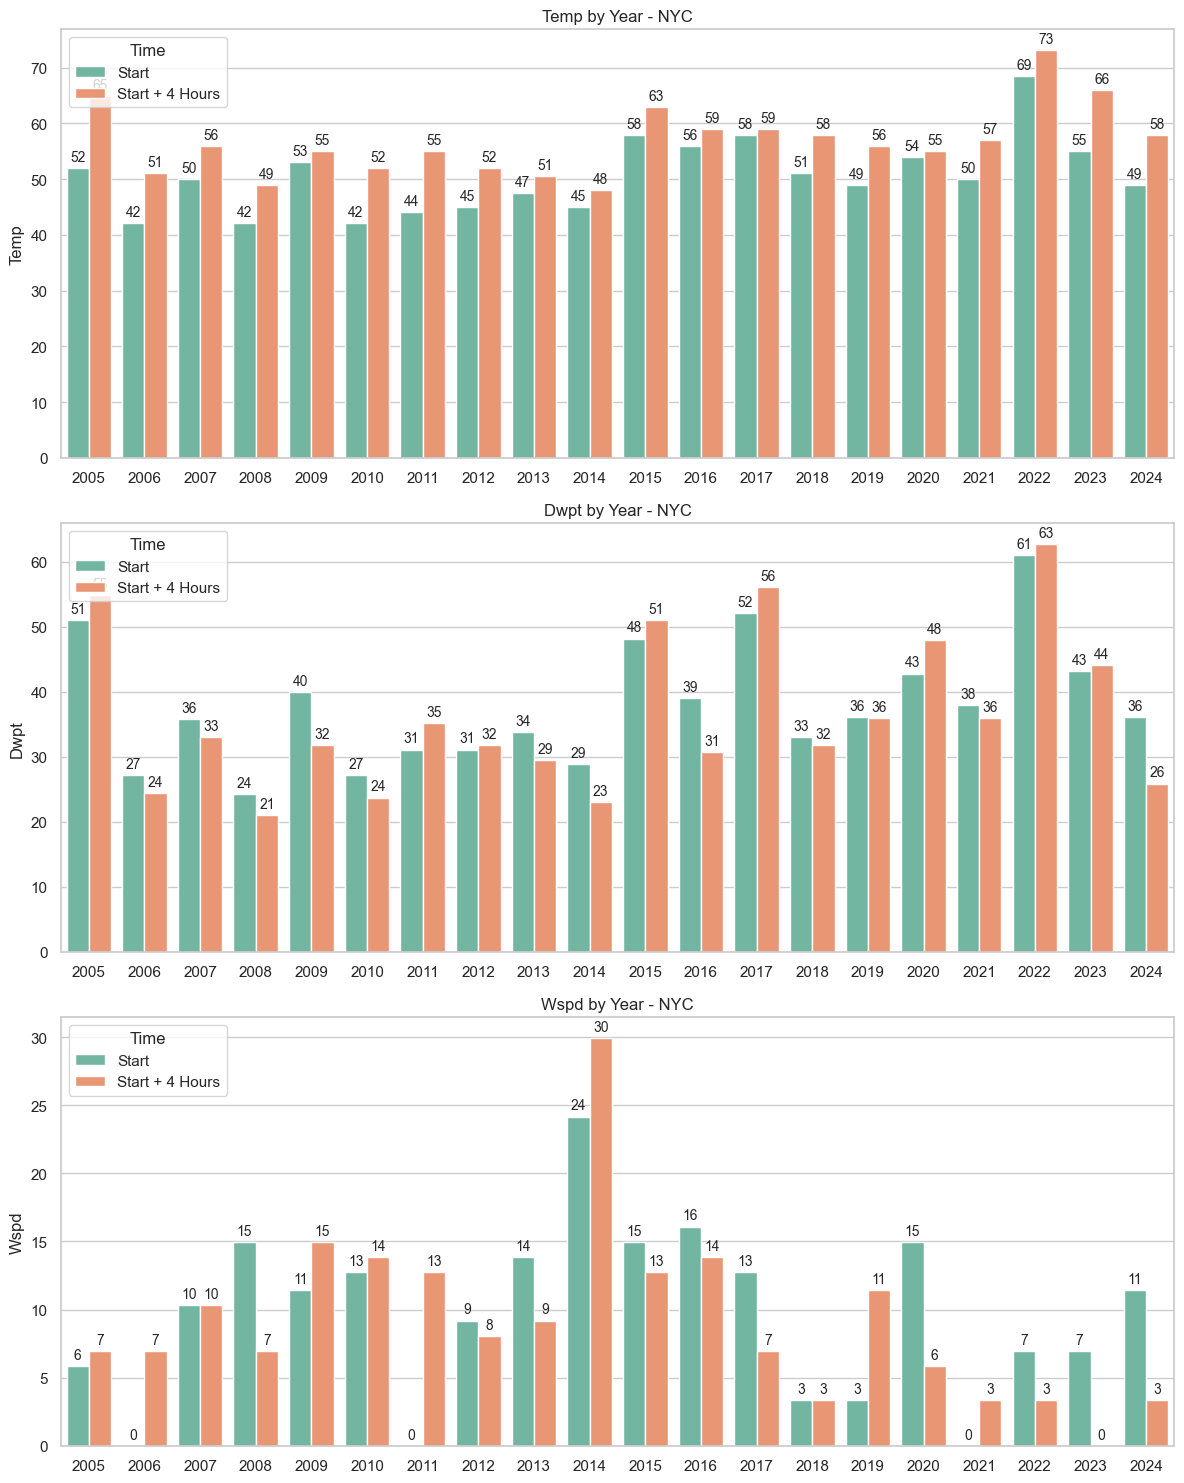

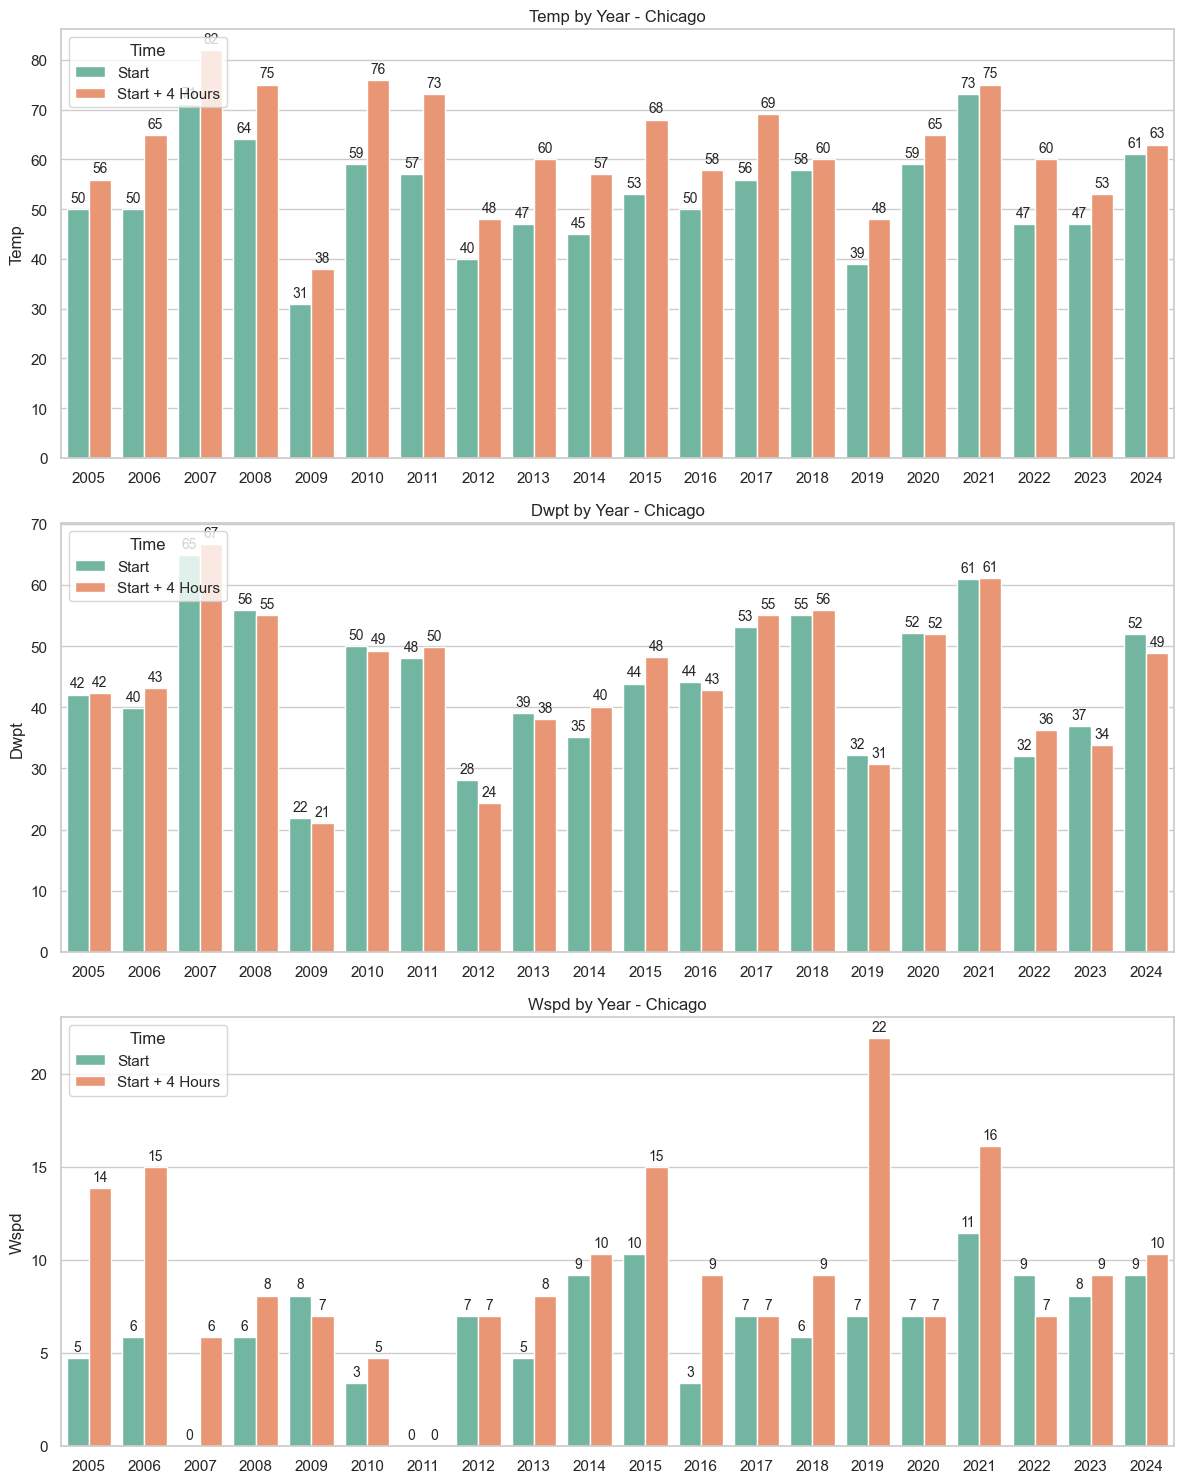

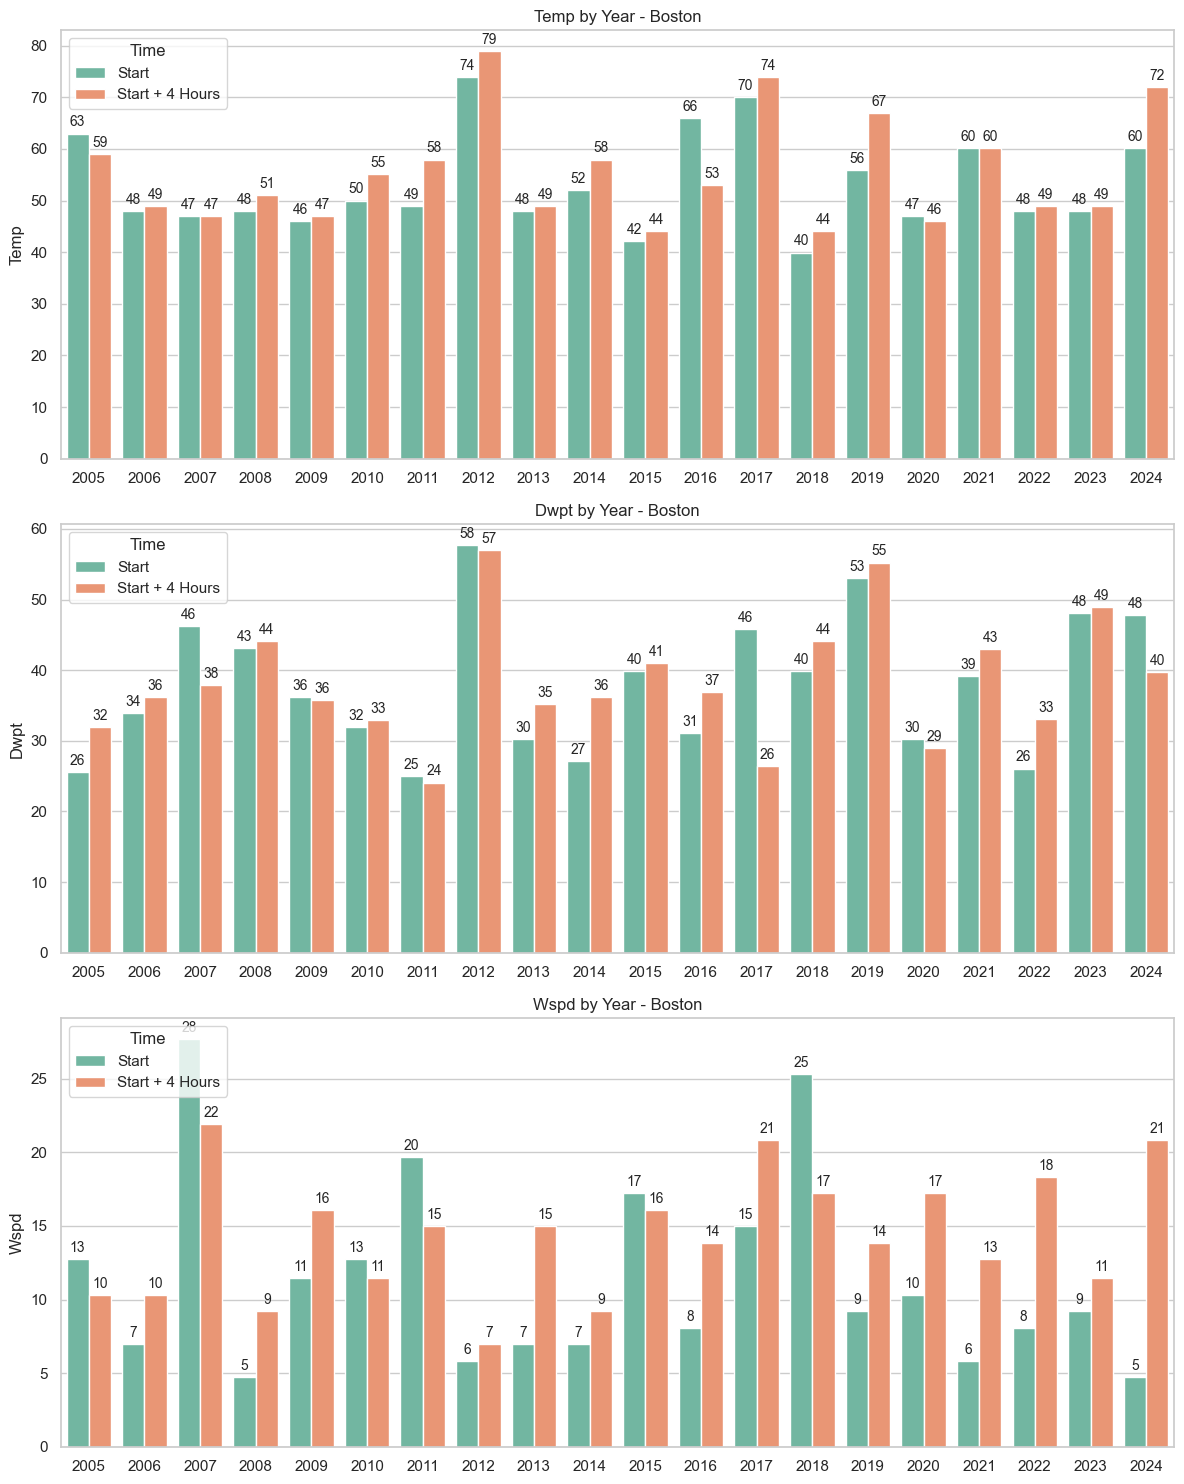

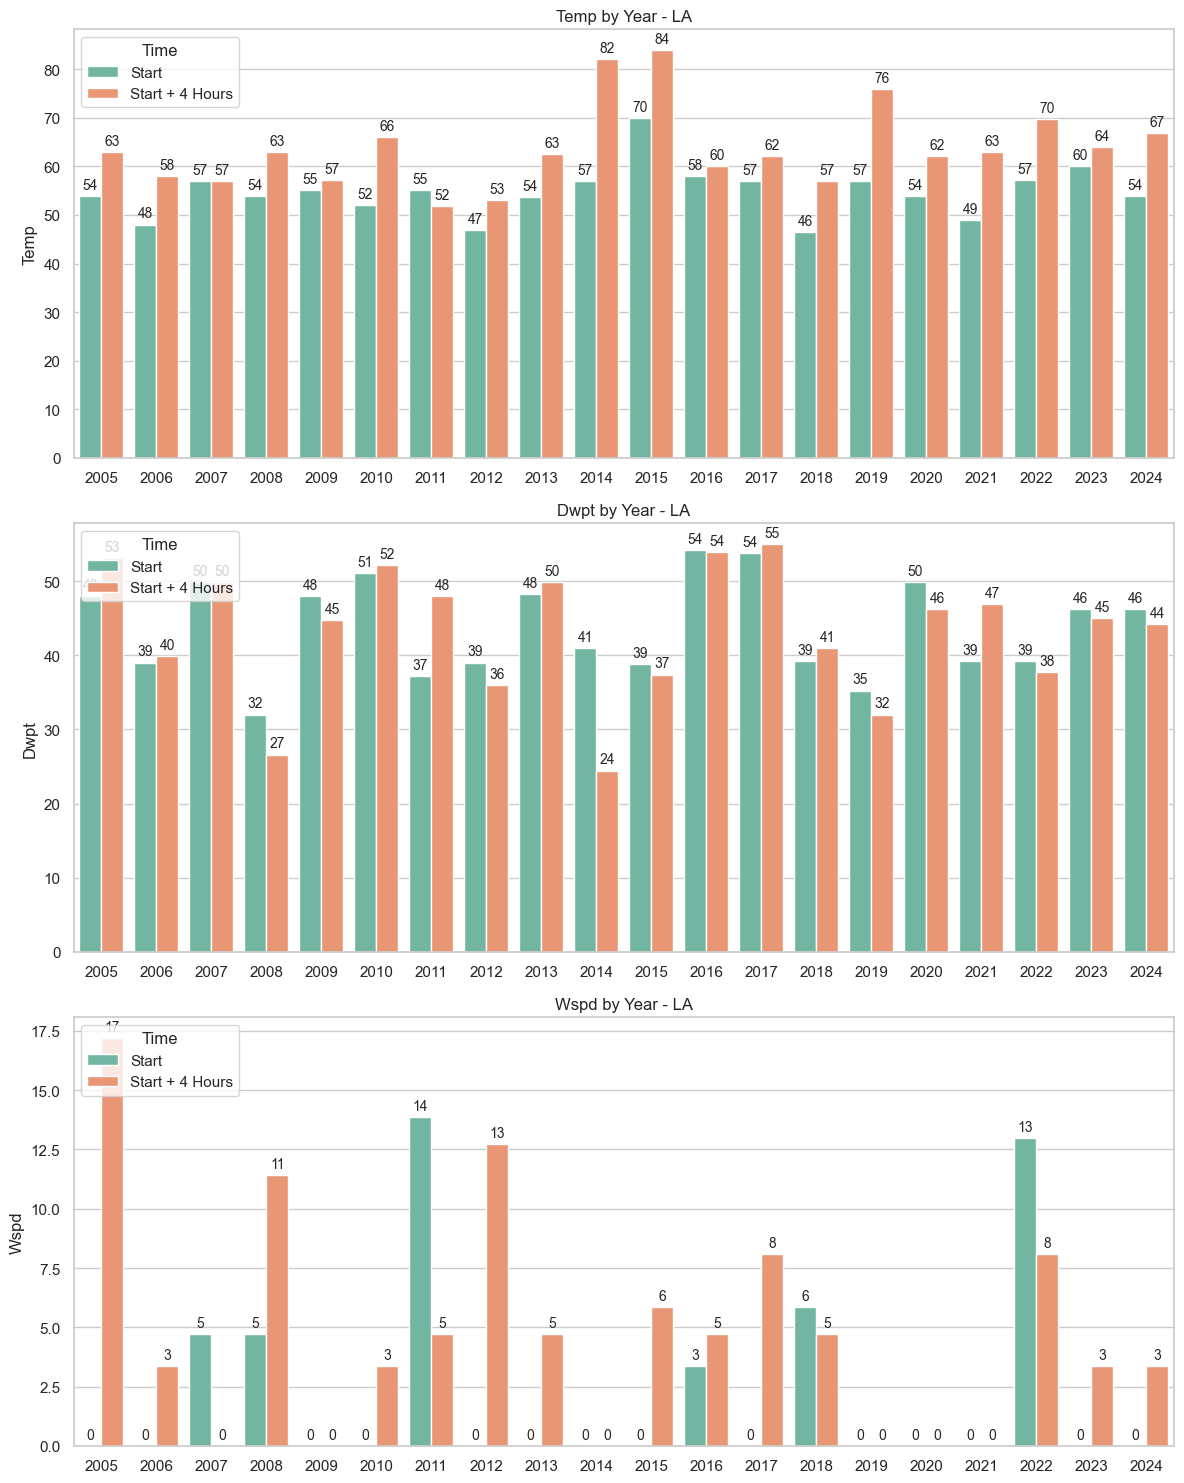

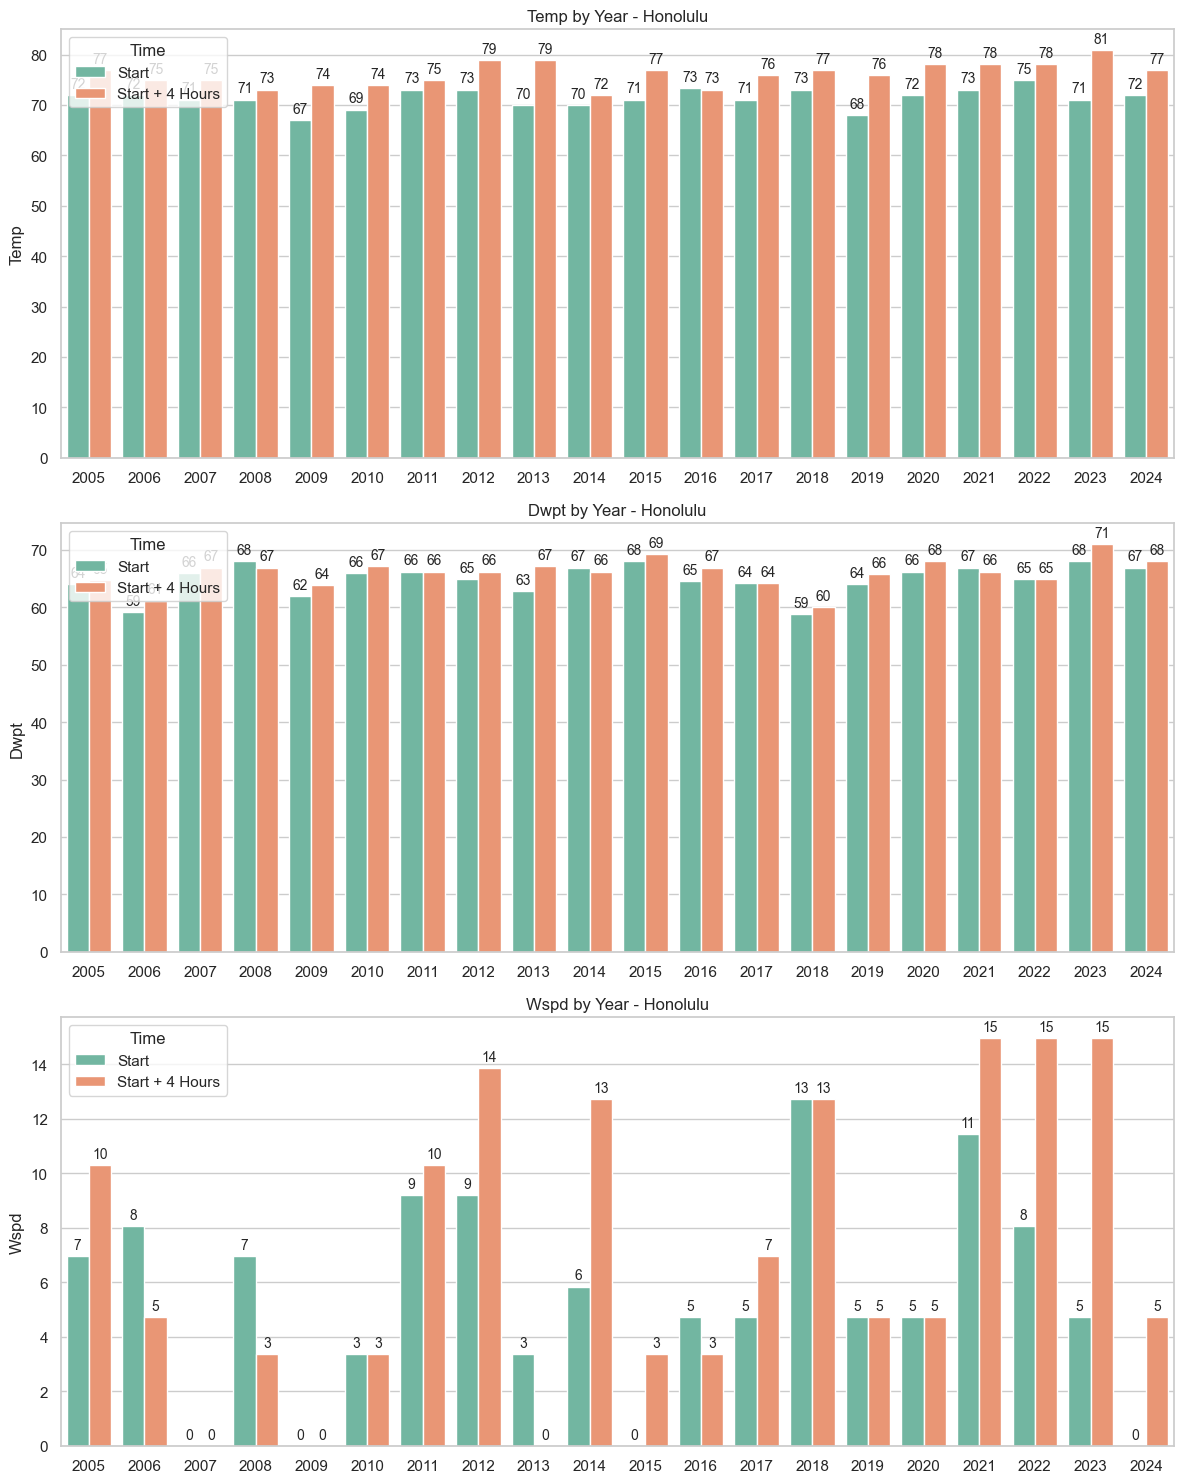

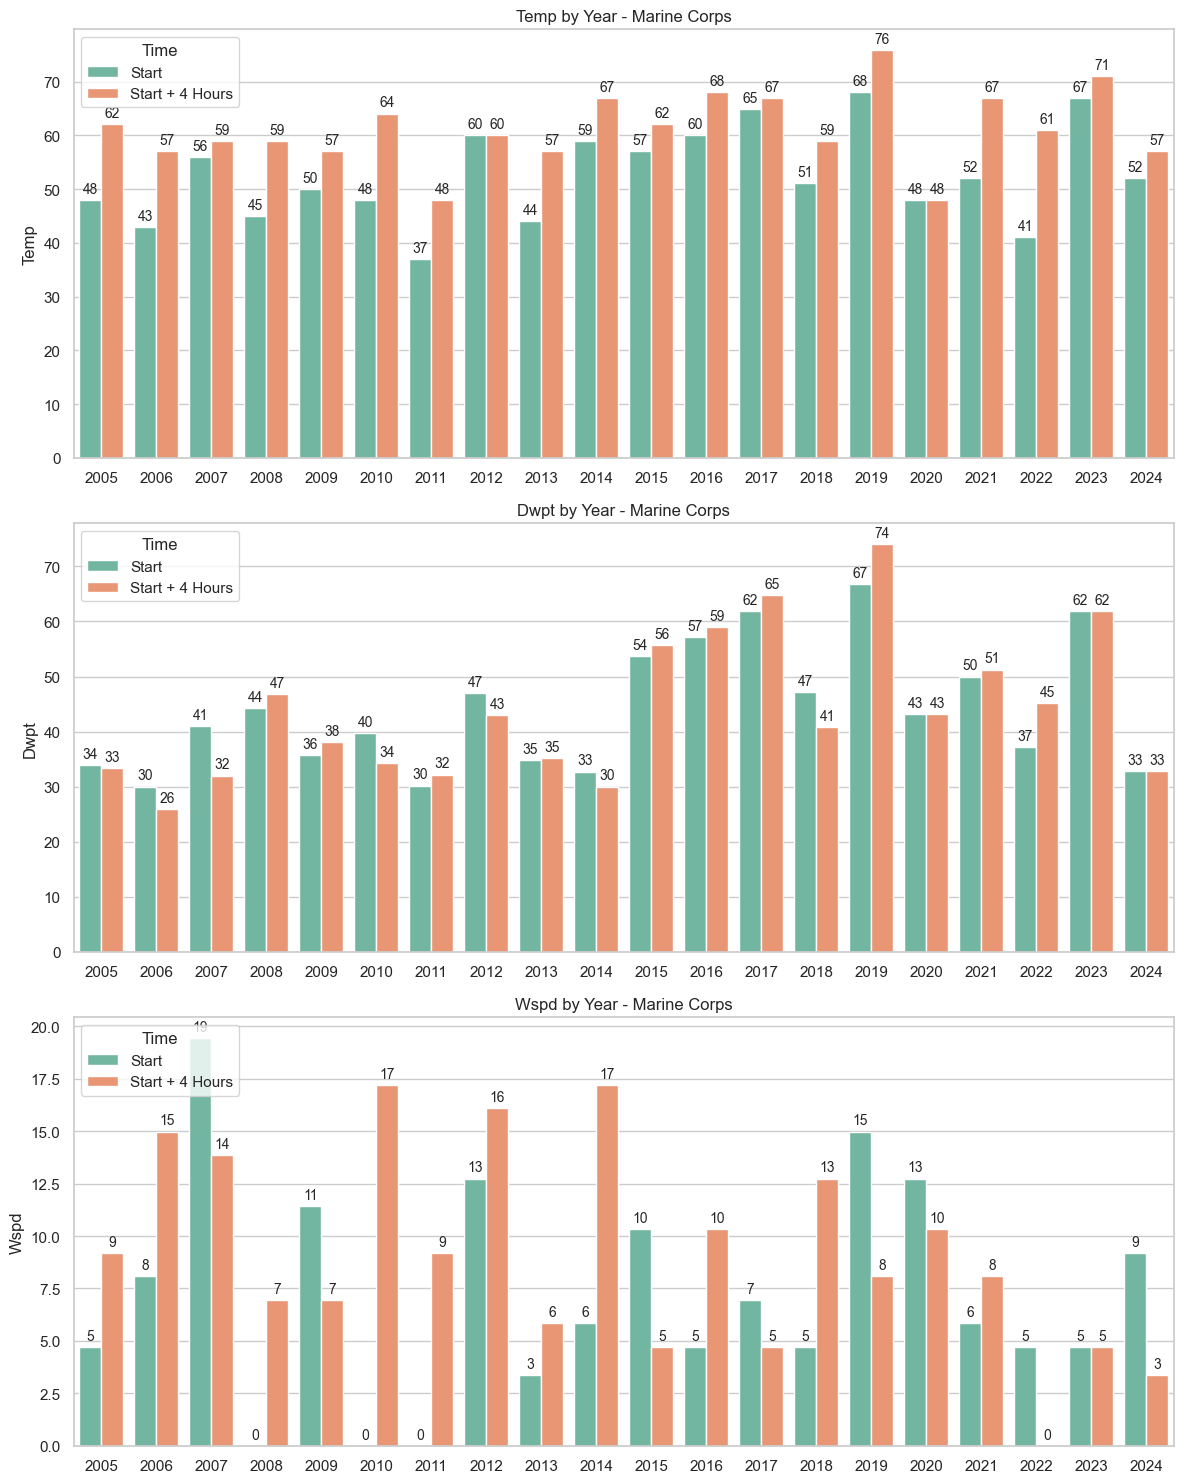

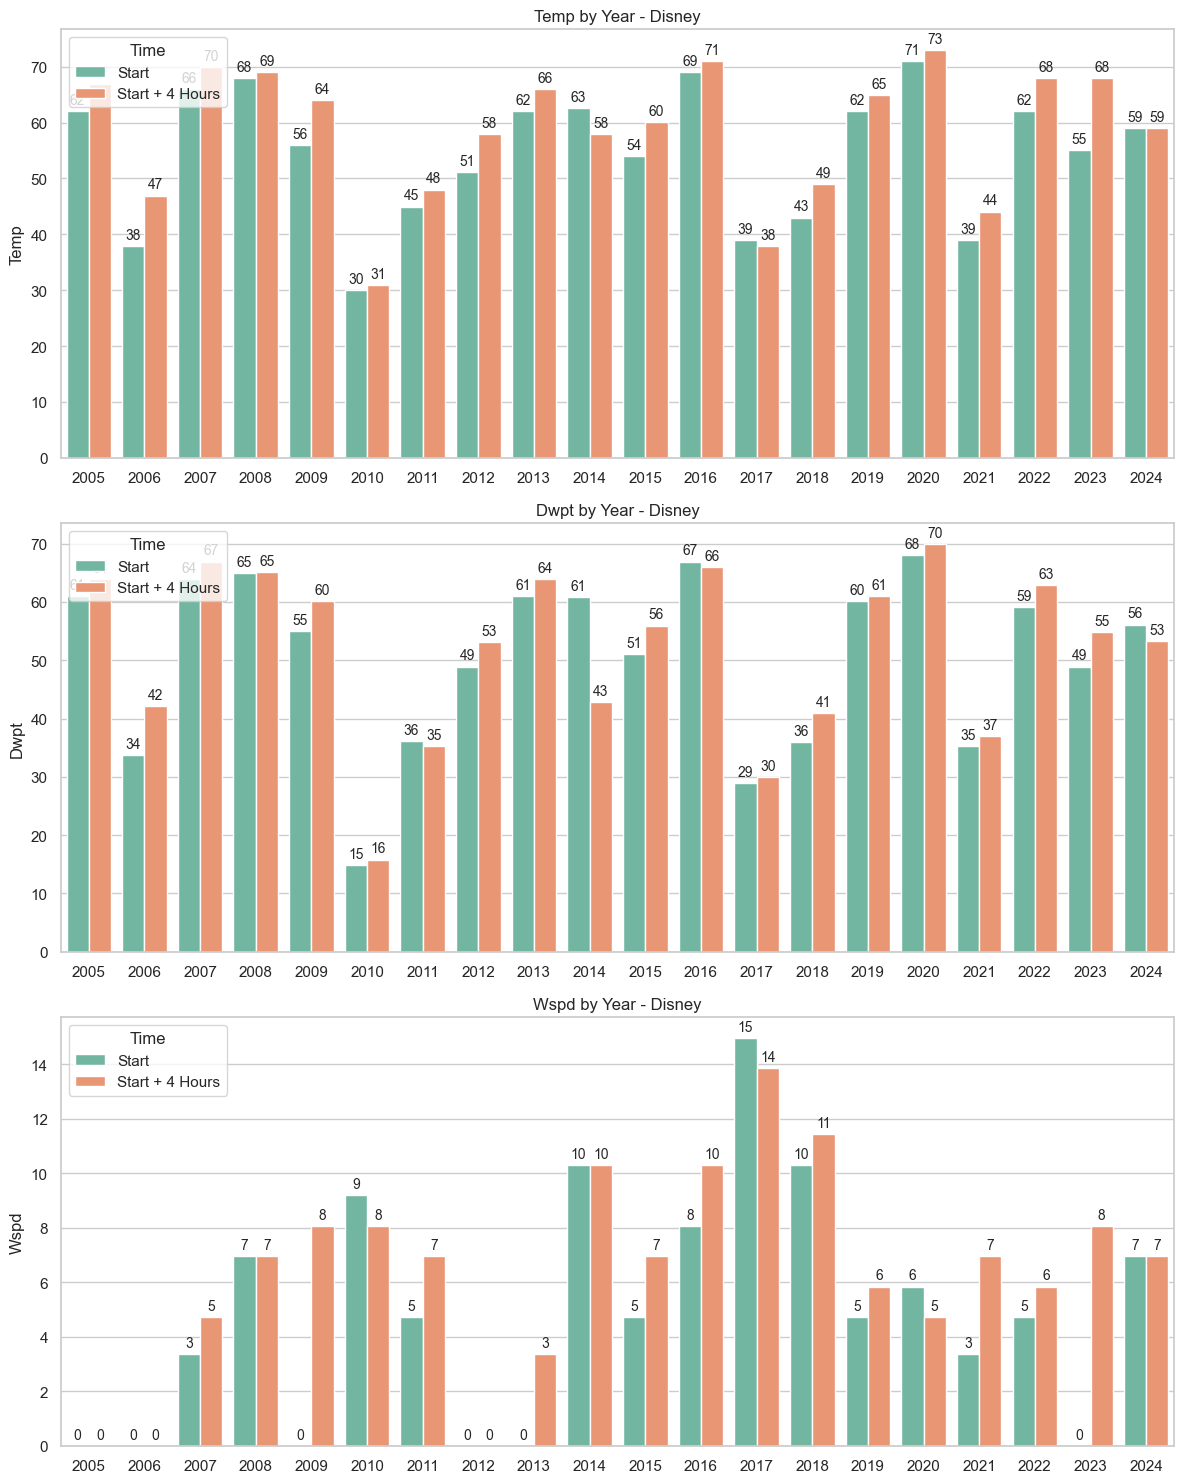

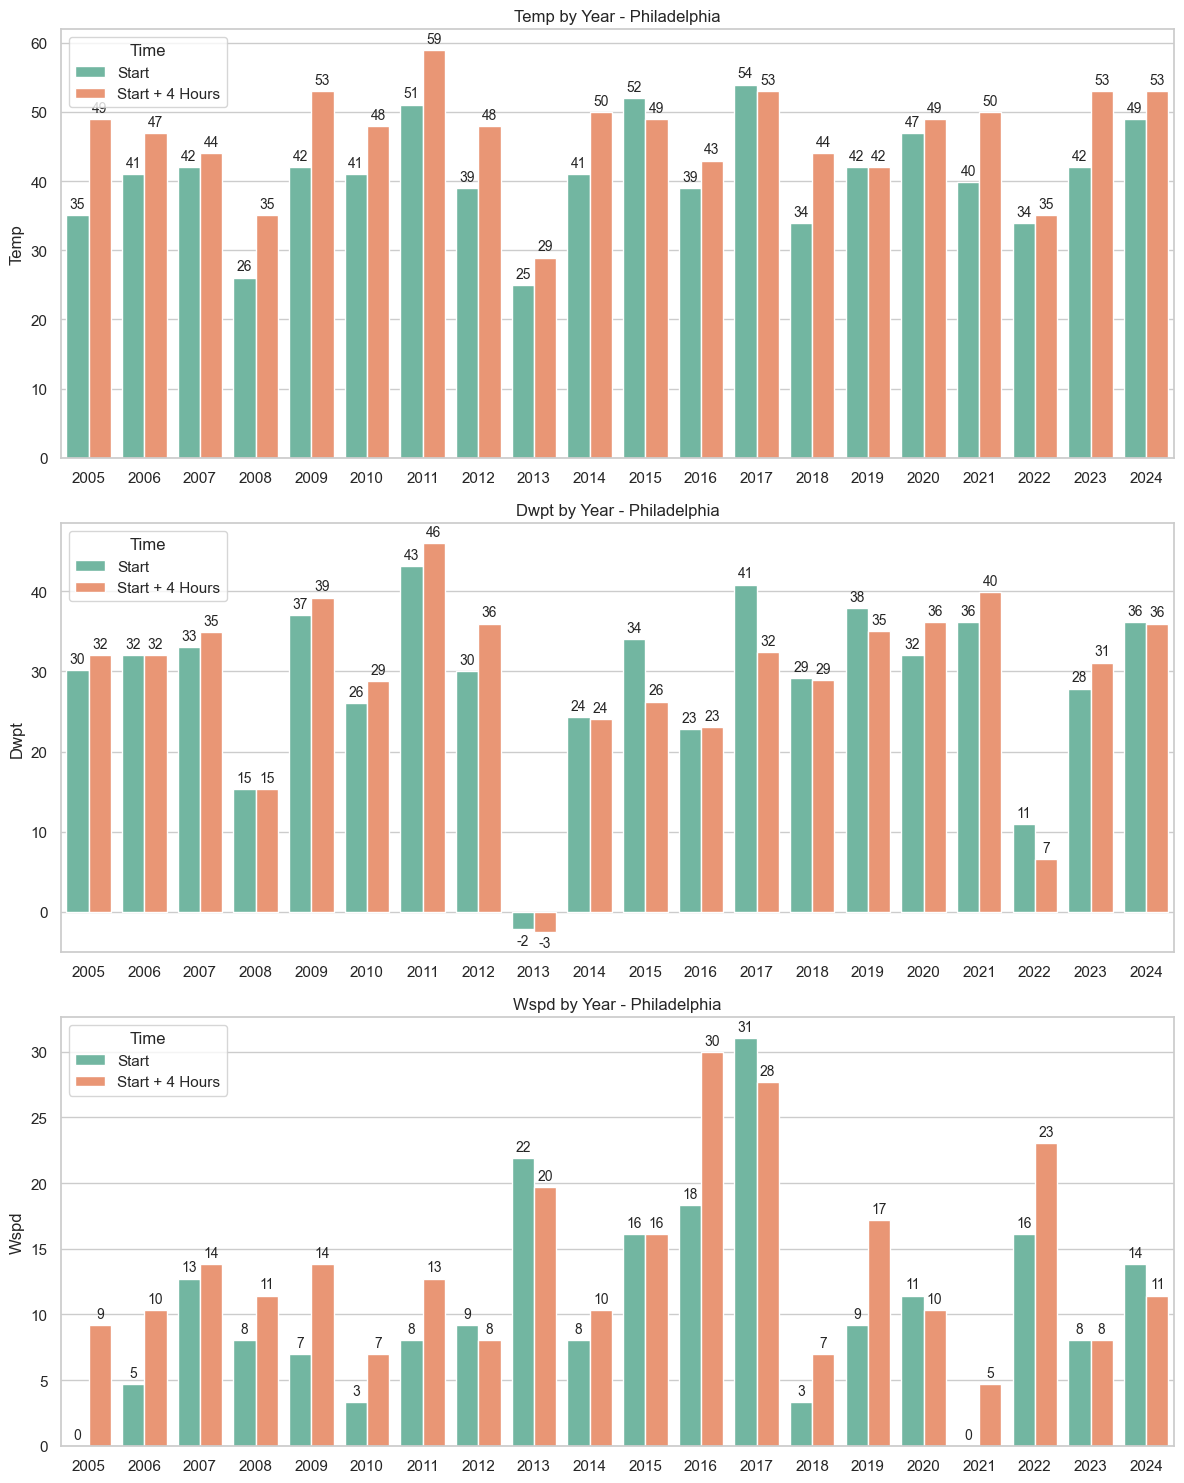

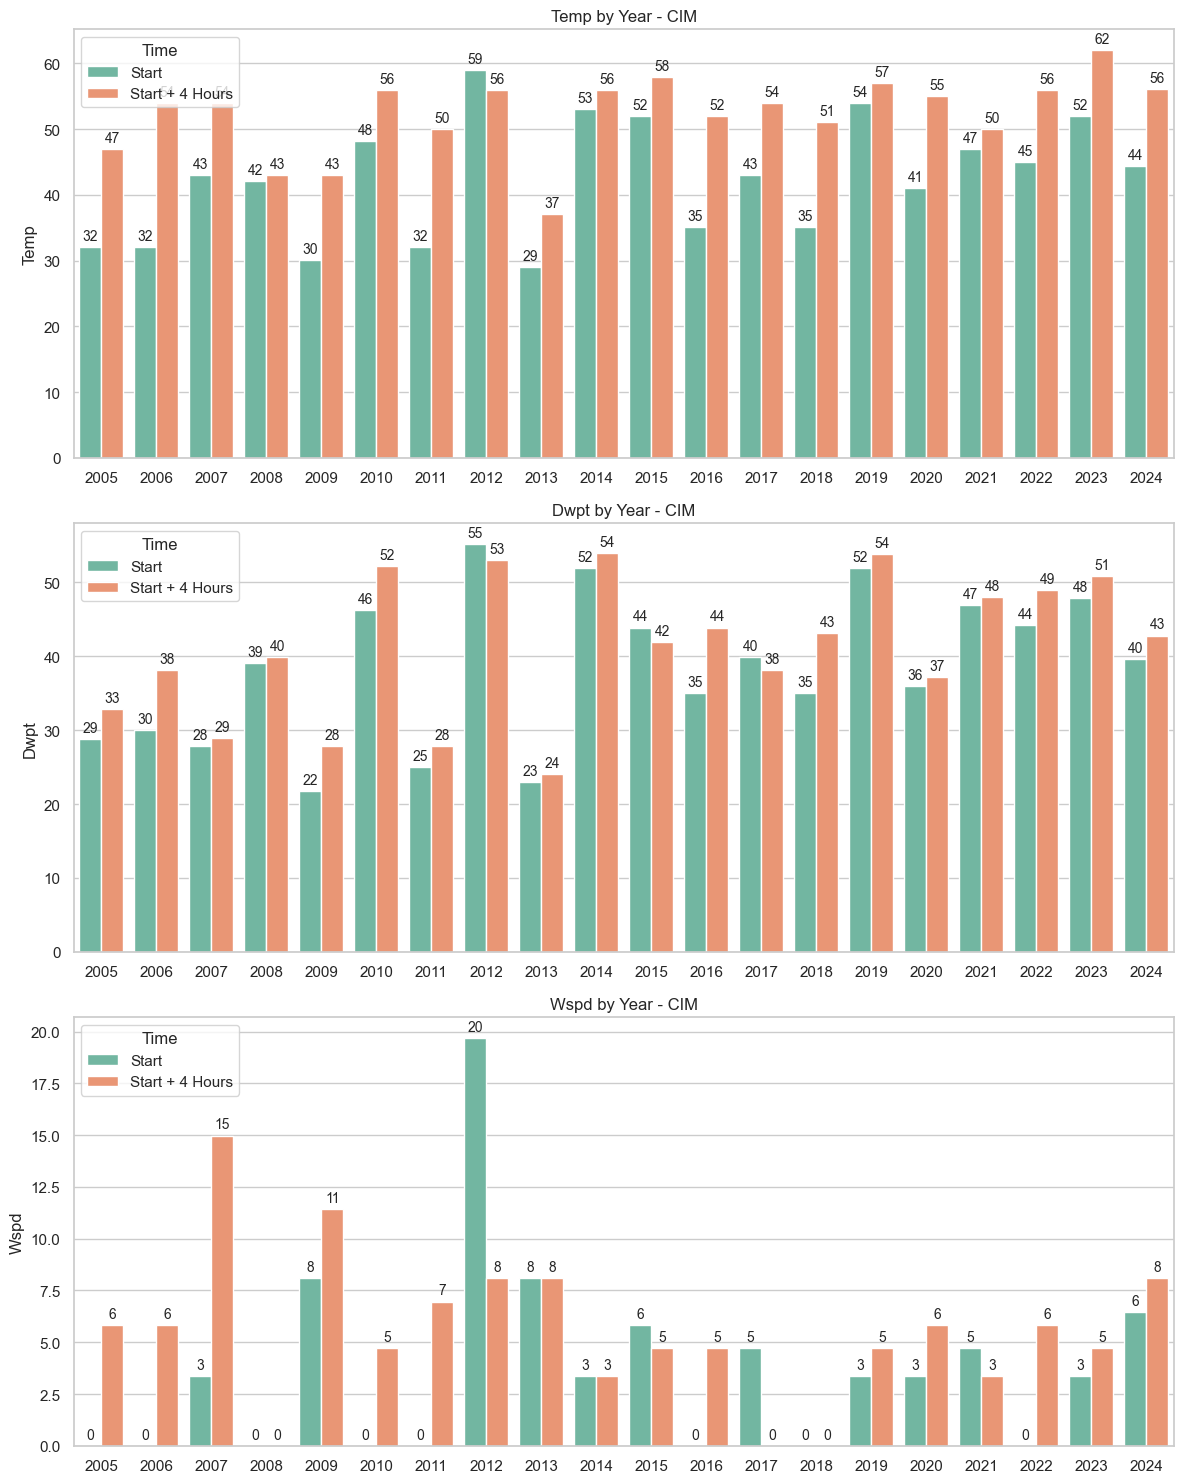

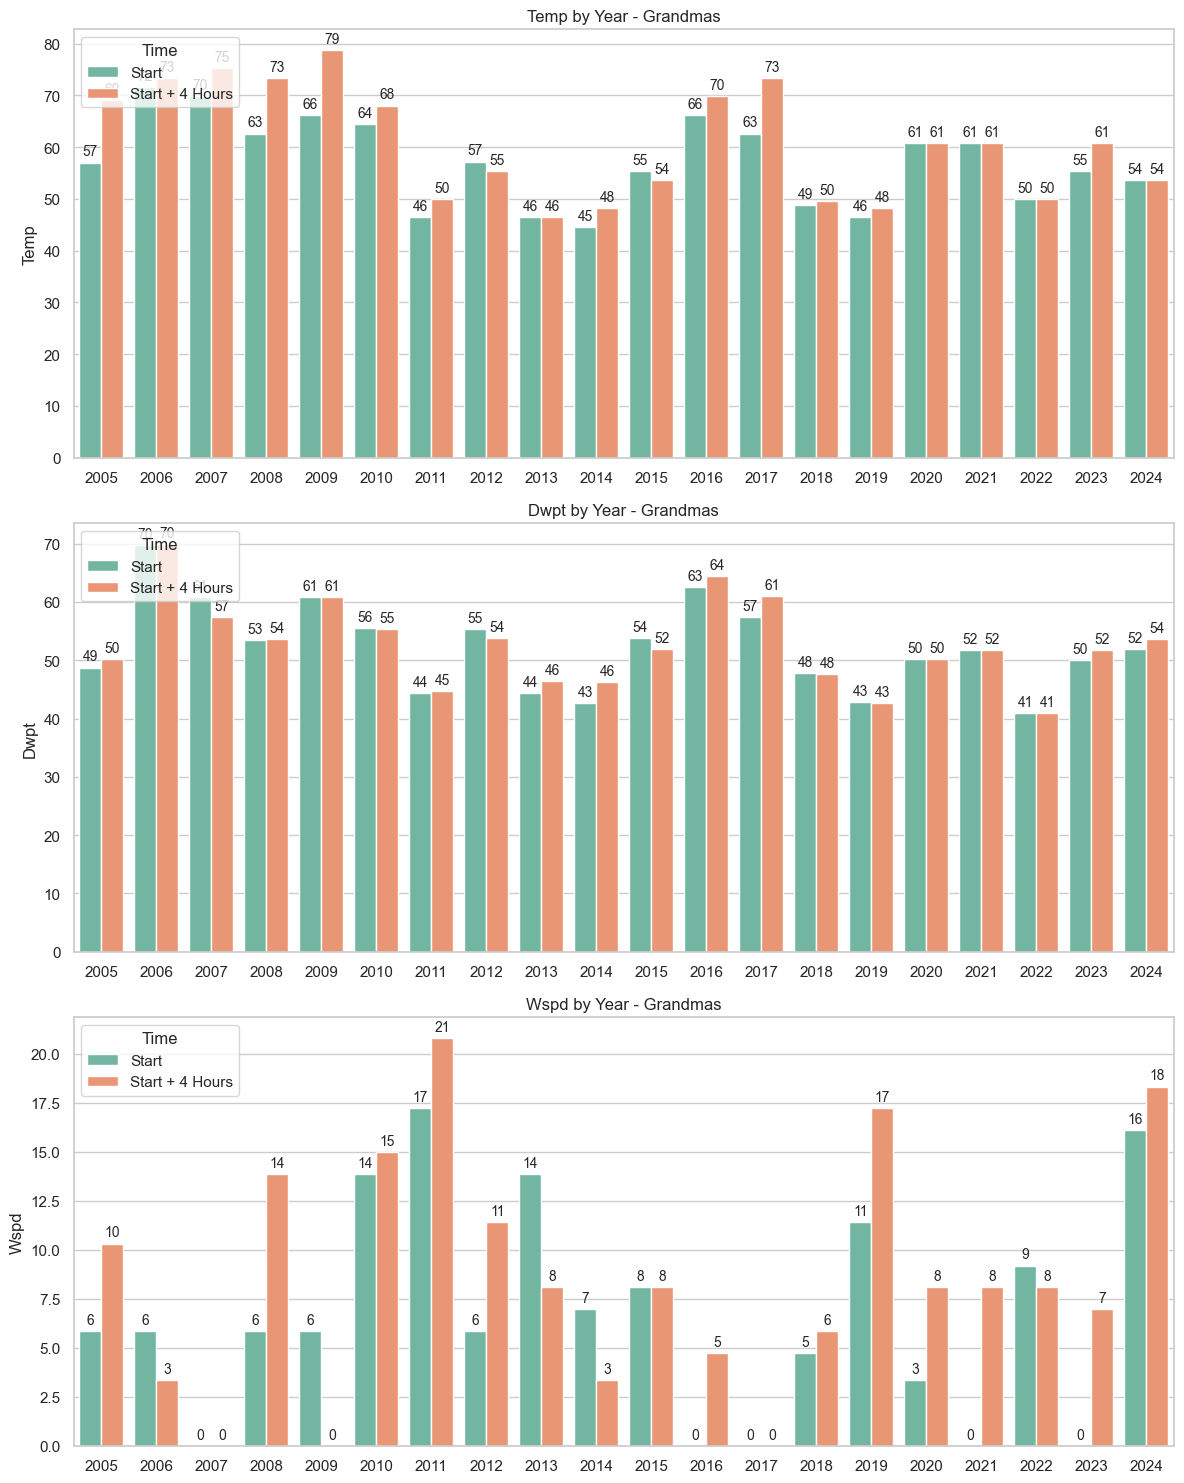

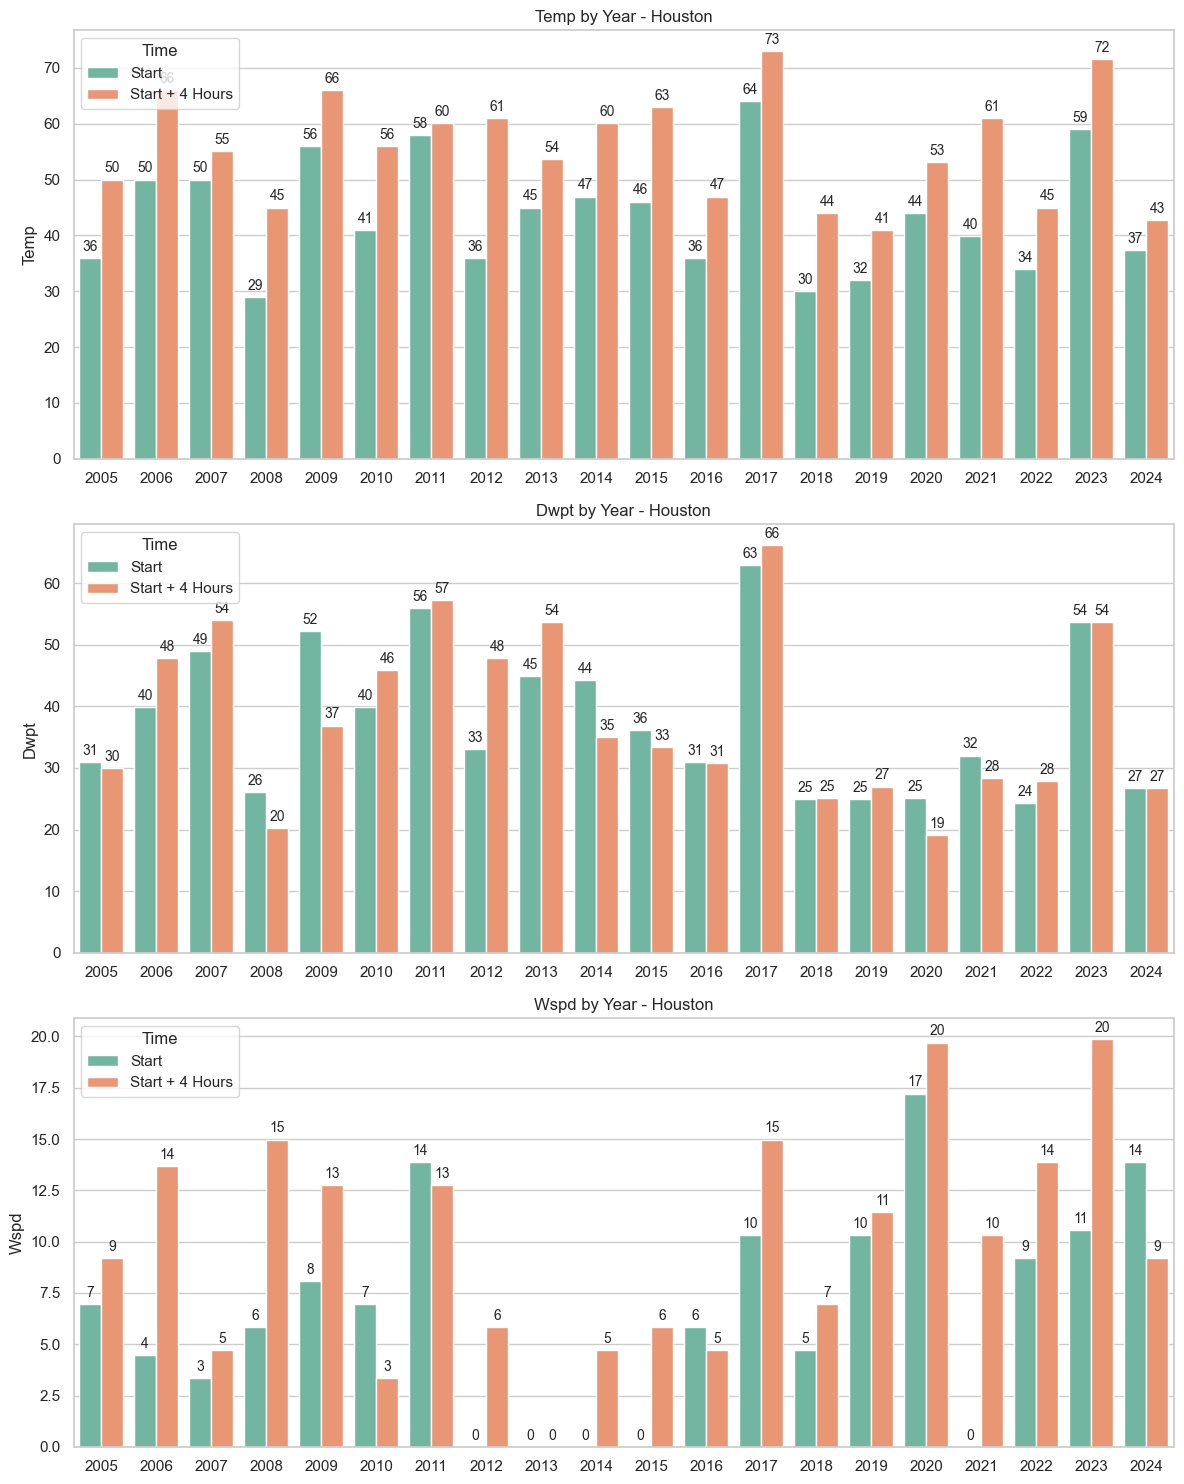

In [530]:
for df in [nyc, chicago, boston, la, honolulu, marine_corps, disney, philadelphia, cim, grandmas, houston]:
    plot_yearly_metrics(df)

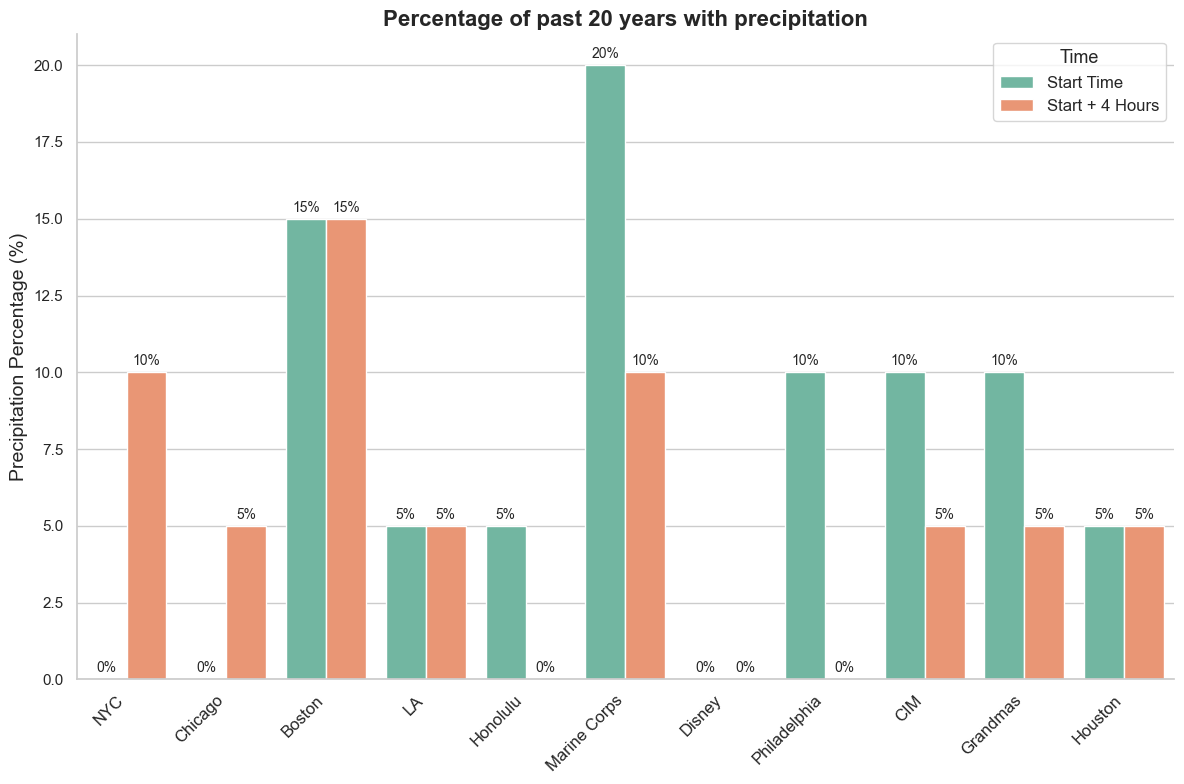

In [531]:
def calculate_precipitation_percentages(df):
    """Calculate the percentage of years with precipitation at start and start + 4 hours."""
    prcp_start_count = (df["prcp_start"] > 0).sum()
    prcp_start_plus_4_count = (df["prcp_start_plus_4"] > 0).sum()

    total_years = len(df)
    prcp_start_percentage = prcp_start_count / total_years * 100
    prcp_start_plus_4_percentage = prcp_start_plus_4_count / total_years * 100

    return {
        "marathon_name": df["marathon_name"].iloc[0],
        "prcp_start": prcp_start_percentage,
        "prcp_start_plus_4": prcp_start_plus_4_percentage,
    }

# List of marathon dataframes
marathon_dataframes = [nyc, chicago, boston, la, honolulu, marine_corps, disney, philadelphia, cim, grandmas, houston]

# Collect precipitation percentages
precipitation_data = [calculate_precipitation_percentages(df) for df in marathon_dataframes]

# Create a DataFrame for plotting
precipitation_df = pd.DataFrame(precipitation_data)

# Reshape data for grouped bar chart
precipitation_melted = precipitation_df.melt(
    id_vars=["marathon_name"],
    value_vars=["prcp_start", "prcp_start_plus_4"],
    var_name="Time",
    value_name="Precipitation Percentage",
)

# Map readable labels
time_labels = {
    "prcp_start": "Start Time",
    "prcp_start_plus_4": "Start + 4 Hours",
}
precipitation_melted["Time"] = precipitation_melted["Time"].map(time_labels)

# Plot the grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=precipitation_melted,
    x="marathon_name",
    y="Precipitation Percentage",
    hue="Time",
    palette="Set2",
)

# Add data labels
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.0f%%", fontsize=10, padding=3)

# Customize the plot
plt.title("Percentage of past 20 years with precipitation", fontsize=16, fontweight="bold")
plt.xlabel("")
plt.ylabel("Precipitation Percentage (%)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.legend(title="Time", fontsize=12, title_fontsize=13)
sns.despine()

plt.tight_layout()
plt.show()

In [532]:
weather_agg = []

for df_agg in [nyc_agg, chicago_agg, boston_agg, la_agg, honolulu_agg, marine_corps_agg, philadelphia_agg, cim_agg, grandmas_agg, houston_agg]:
    weather_agg.append(df_agg)

weather_agg_all = pd.concat(weather_agg)

In [537]:
# Pivot the data
pivot_df = weather_agg_all.pivot_table(
    index='marathon_name',
    columns='index',
    values=[
        'temp_start', 'temp_start_plus_4', 
        'rhum_start', 'rhum_start_plus_4',
        'dwpt_start', 'dwpt_start_plus_4', 
        'wspd_start', 'wspd_start_plus_4'
    ],
    aggfunc='first'
)

In [538]:
pivot_df

dwpt_start                           dwpt_start_plus_4          \
index                max    mean    min        std               max    mean   
marathon_name                                                                  
Boston             57.74  37.913  24.98   9.703543             57.02  38.426   
CIM                55.22  38.462  21.74  10.105665             53.96  41.378   
Chicago            64.94  44.357  21.92  11.367602             66.74  44.735   
Grandmas           69.80  52.268  41.00   7.556706             69.98  52.727   
Honolulu           68.00  64.931  58.82   2.638656             71.06  66.047   
Houston            62.96  37.895  24.26  11.981463             66.20  38.336   
LA                 54.14  43.763  32.00   6.472963             55.04  43.205   
Marine Corps       66.74  44.069  30.02  11.336988             74.12  43.988   
NYC                60.98  37.994  24.26   9.497291             62.78  36.545   
Philadelphia       43.16  28.832  -2.20  10.777935             46.04  29.048   

                                rhum_start         ... temp_start_plus_4  \
index            min        std        max   mean  ...               min   
marathon_name                                      ...                     
Boston         24.08   8.587359      100.0  60.95  ...             44.06   
CIM            24.08   9.459473      100.0  86.40  ...             37.04   
Chicago        21.02  11.845338       90.0  73.10  ...             37.94   
Grandmas       41.00   7.344045       97.0  83.90  ...             46.40   
Honolulu       60.08   2.494341       90.0  80.50  ...             71.96   
Houston        19.04  13.738164      100.0  81.30  ...             41.00   
LA             24.44   8.760906       97.0  68.80  ...             51.80   
Marine Corps   25.88  13.261545       97.0  74.65  ...             48.02   
NYC            21.02  12.183988       97.0  62.55  ...             48.02   
Philadelphia   -2.56  11.516654       86.0  63.75  ...             28.94   

                         wspd_start                                \
index                std        max       mean      min       std   
marathon_name                                                       
Boston         10.347380  27.713147  11.433226  4.72242  6.573964   
CIM             5.982195  19.697461   3.718905  0.00000  4.694118   
Chicago        10.991347  11.433226   6.350412  0.00000  3.060568   
Grandmas       10.819735  17.211977   6.698379  0.00000  5.501248   
Honolulu        2.337065  12.738105   5.440103  0.00000  3.739789   
Houston         9.687507  17.211977   6.577212  0.00000  5.170435   
LA              8.558552  13.856573   2.274218  0.00000  4.274734   
Marine Corps    6.885373  19.448912   7.226545  0.00000  5.175535   
NYC             6.237734  24.171332   9.668533  0.00000  6.361168   
Philadelphia    7.213600  31.068550  10.532238  0.00000  7.574894   

              wspd_start_plus_4                                 
index                       max       mean       min       std  
marathon_name                                                   
Boston                21.934396  14.387846  6.959355  4.233994  
CIM                   14.975041   5.564377  0.000000  3.630271  
Chicago               21.934396   9.578434  0.000000  4.819291  
Grandmas              20.815929   8.578027  0.000000  6.073680  
Honolulu              14.975041   7.207904  0.000000  5.359018  
Houston               19.883872   9.941936  0.000000  5.426544  
LA                    17.211977   4.784557  0.000000  4.758642  
Marine Corps          17.211977   9.227359  0.000000  4.859695  
NYC                   29.950082   9.211825  0.000000  6.458165  
Philadelphia          29.950082  13.598704  4.722420  6.891405  

[10 rows x 32 columns]

In [539]:
def plot_and_save_aggregated_metrics(pivot_df):
    """
    Plots and saves bar charts for aggregated metrics for each marathon.
    """
    metrics = ['temp', 'rhum', 'dwpt', 'wspd']
    aggregations = ['min', 'mean', 'max', 'std']

    for metric in metrics:
        for aggregation in aggregations:
            # Extract the relevant data
            column_name = f"{metric}_start"
            column_name_plus_4 = f"{metric}_start_plus_4"
            y_values = pivot_df[(column_name, aggregation)]
            y_values_plus_4 = pivot_df[(column_name_plus_4, aggregation)]

            # Bar chart setup
            fig, ax = plt.subplots(figsize=(10, 6))
            x_labels = pivot_df.index
            width = 0.35
            x = range(len(x_labels))
            colors = sns.color_palette("Set2", n_colors=2)

            if metric == "std":
                metric = "stdev"

            # Bar plots
            bars1 = ax.bar(
                [pos - width / 2 for pos in x],
                y_values,
                width=width,
                label=f"{metric.capitalize()} Start",
                color=colors[0],
            )
            bars2 = ax.bar(
                [pos + width / 2 for pos in x],
                y_values_plus_4,
                width=width,
                label=f"{metric.capitalize()} Start + 4 Hours",
                color=colors[1],
            )

            # Add data labels for each bar
            for bar in bars1:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.5,
                    f"{height:.1f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )
            for bar in bars2:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.5,
                    f"{height:.1f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

            # Formatting
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels, rotation=45, ha="right")
            ax.set_ylabel(f"{metric.capitalize()} ({aggregation.capitalize()})")
            ax.set_title(
                f"{metric.capitalize()} ({aggregation.capitalize()}) Comparison",
                fontsize=14,
                fontweight="bold",
            )
            ax.legend()
            sns.despine()

            plt.show()

In [540]:
pivot_df

dwpt_start                           dwpt_start_plus_4          \
index                max    mean    min        std               max    mean   
marathon_name                                                                  
Boston             57.74  37.913  24.98   9.703543             57.02  38.426   
CIM                55.22  38.462  21.74  10.105665             53.96  41.378   
Chicago            64.94  44.357  21.92  11.367602             66.74  44.735   
Grandmas           69.80  52.268  41.00   7.556706             69.98  52.727   
Honolulu           68.00  64.931  58.82   2.638656             71.06  66.047   
Houston            62.96  37.895  24.26  11.981463             66.20  38.336   
LA                 54.14  43.763  32.00   6.472963             55.04  43.205   
Marine Corps       66.74  44.069  30.02  11.336988             74.12  43.988   
NYC                60.98  37.994  24.26   9.497291             62.78  36.545   
Philadelphia       43.16  28.832  -2.20  10.777935             46.04  29.048   

                                rhum_start         ... temp_start_plus_4  \
index            min        std        max   mean  ...               min   
marathon_name                                      ...                     
Boston         24.08   8.587359      100.0  60.95  ...             44.06   
CIM            24.08   9.459473      100.0  86.40  ...             37.04   
Chicago        21.02  11.845338       90.0  73.10  ...             37.94   
Grandmas       41.00   7.344045       97.0  83.90  ...             46.40   
Honolulu       60.08   2.494341       90.0  80.50  ...             71.96   
Houston        19.04  13.738164      100.0  81.30  ...             41.00   
LA             24.44   8.760906       97.0  68.80  ...             51.80   
Marine Corps   25.88  13.261545       97.0  74.65  ...             48.02   
NYC            21.02  12.183988       97.0  62.55  ...             48.02   
Philadelphia   -2.56  11.516654       86.0  63.75  ...             28.94   

                         wspd_start                                \
index                std        max       mean      min       std   
marathon_name                                                       
Boston         10.347380  27.713147  11.433226  4.72242  6.573964   
CIM             5.982195  19.697461   3.718905  0.00000  4.694118   
Chicago        10.991347  11.433226   6.350412  0.00000  3.060568   
Grandmas       10.819735  17.211977   6.698379  0.00000  5.501248   
Honolulu        2.337065  12.738105   5.440103  0.00000  3.739789   
Houston         9.687507  17.211977   6.577212  0.00000  5.170435   
LA              8.558552  13.856573   2.274218  0.00000  4.274734   
Marine Corps    6.885373  19.448912   7.226545  0.00000  5.175535   
NYC             6.237734  24.171332   9.668533  0.00000  6.361168   
Philadelphia    7.213600  31.068550  10.532238  0.00000  7.574894   

              wspd_start_plus_4                                 
index                       max       mean       min       std  
marathon_name                                                   
Boston                21.934396  14.387846  6.959355  4.233994  
CIM                   14.975041   5.564377  0.000000  3.630271  
Chicago               21.934396   9.578434  0.000000  4.819291  
Grandmas              20.815929   8.578027  0.000000  6.073680  
Honolulu              14.975041   7.207904  0.000000  5.359018  
Houston               19.883872   9.941936  0.000000  5.426544  
LA                    17.211977   4.784557  0.000000  4.758642  
Marine Corps          17.211977   9.227359  0.000000  4.859695  
NYC                   29.950082   9.211825  0.000000  6.458165  
Philadelphia          29.950082  13.598704  4.722420  6.891405  

[10 rows x 32 columns]

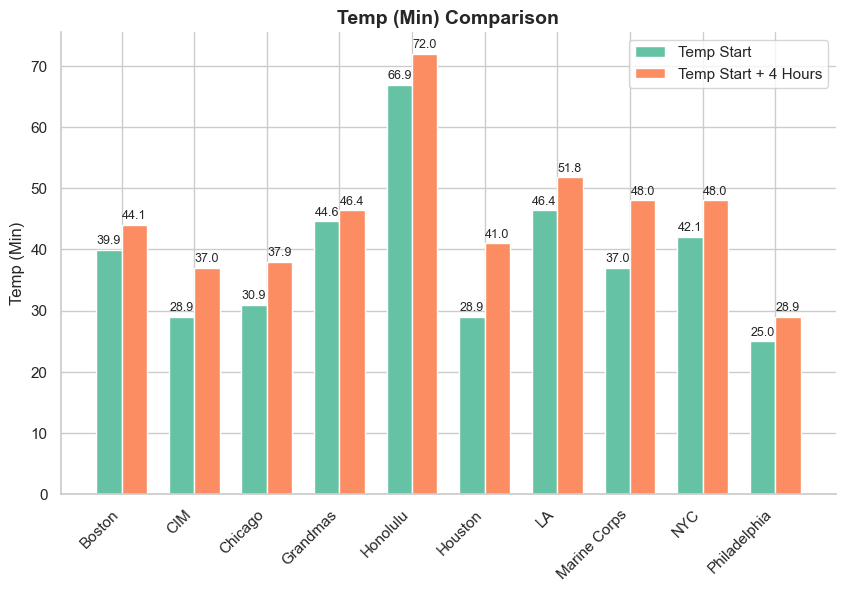

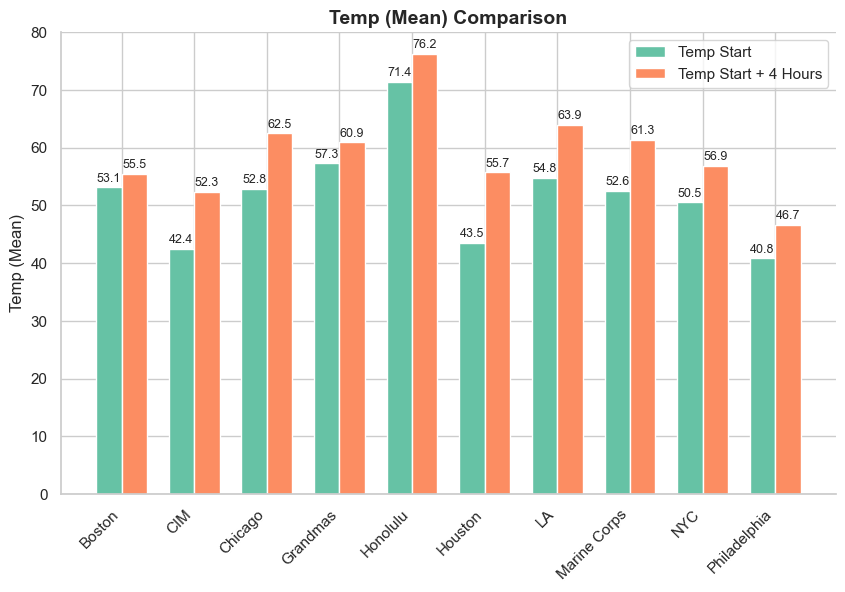

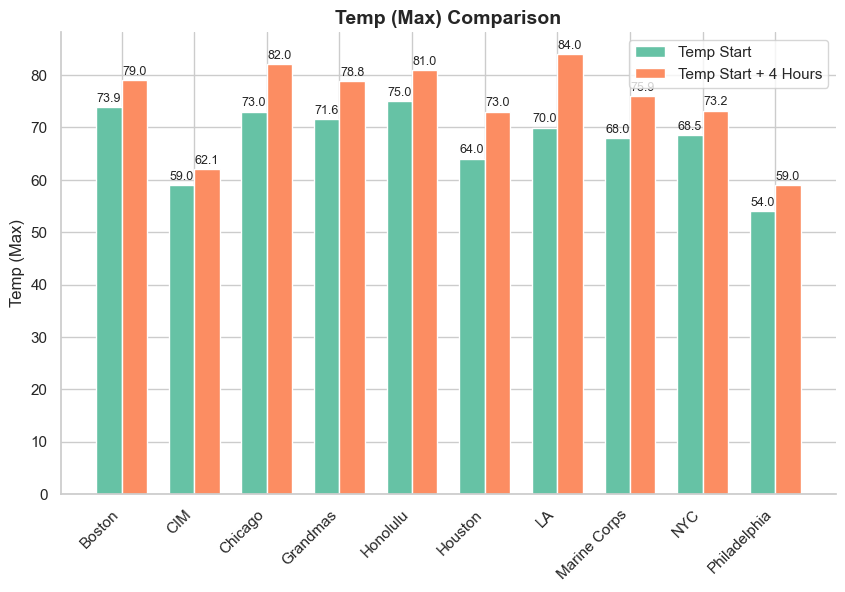

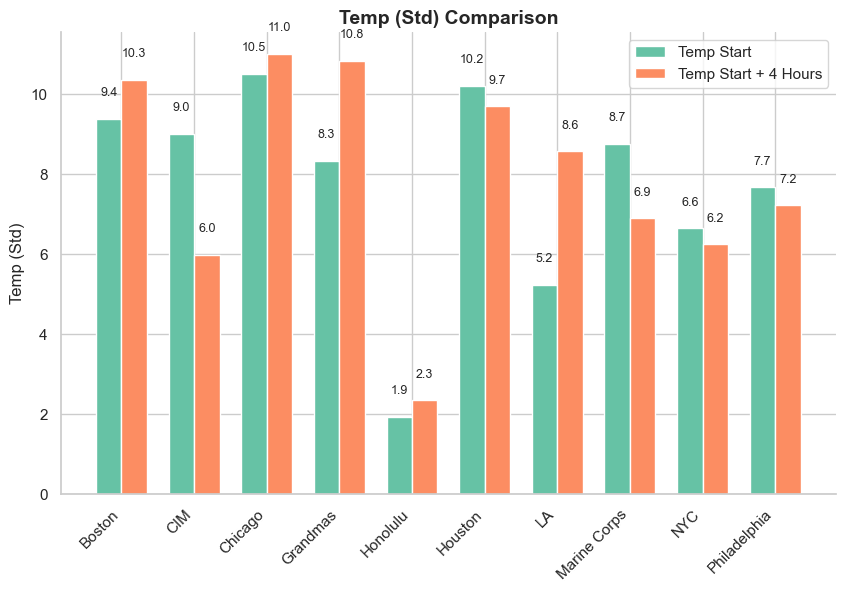

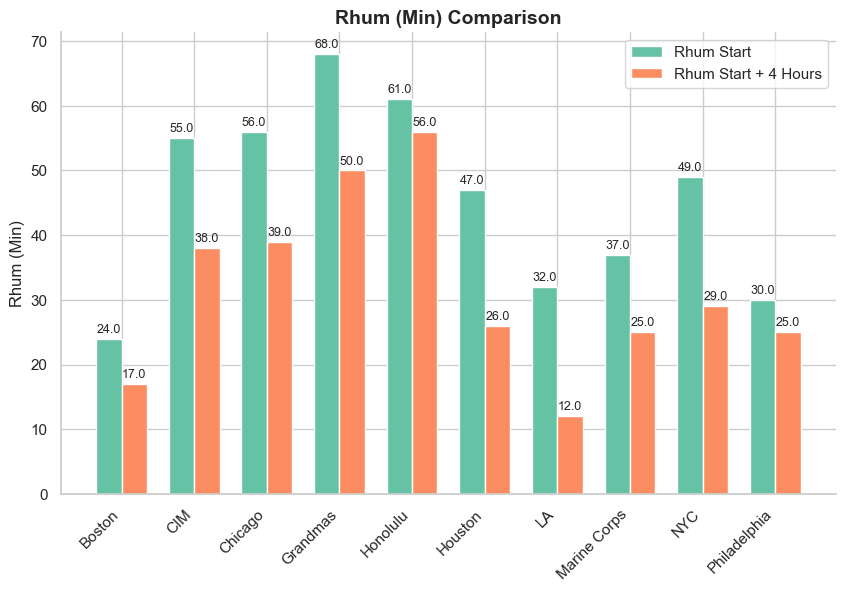

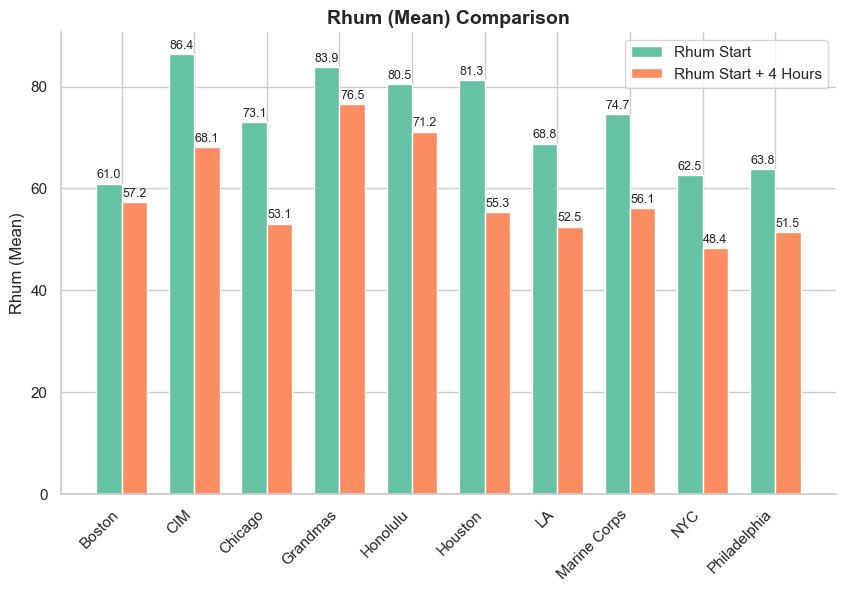

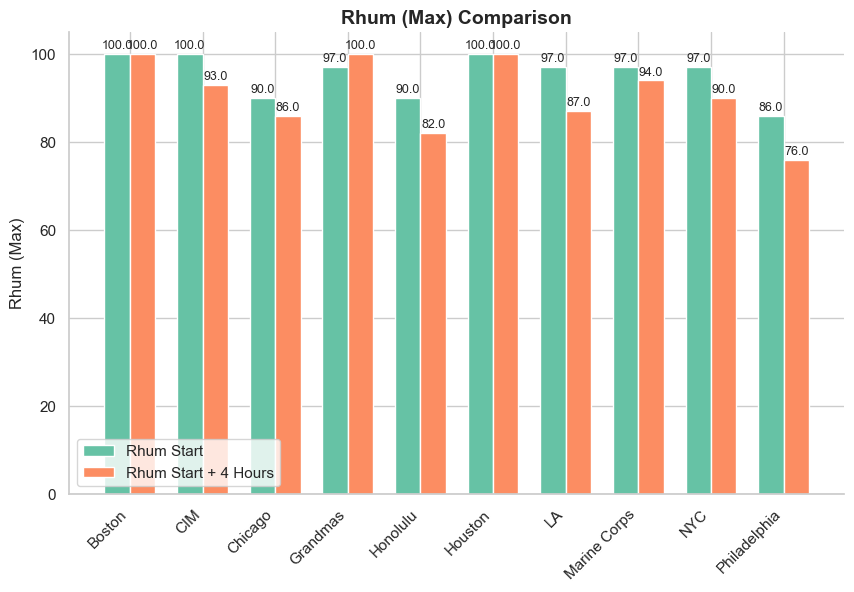

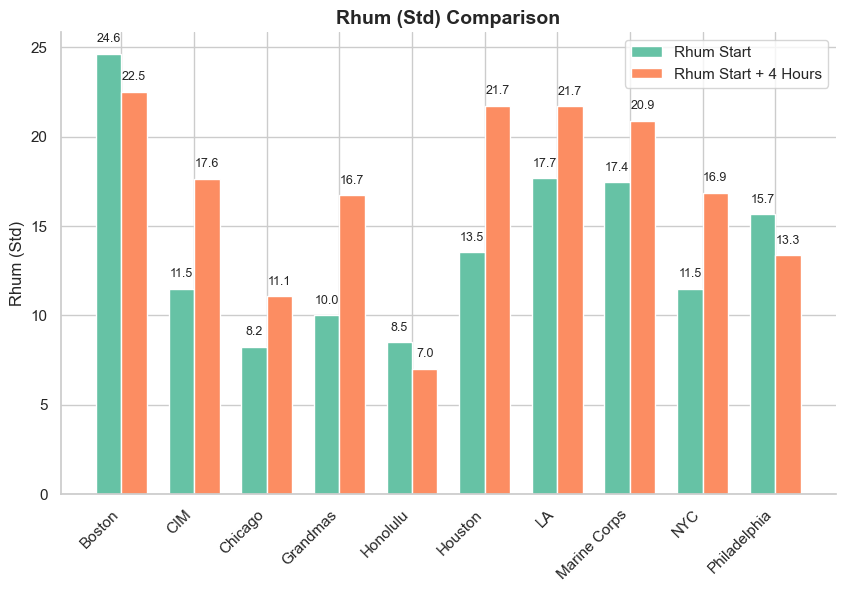

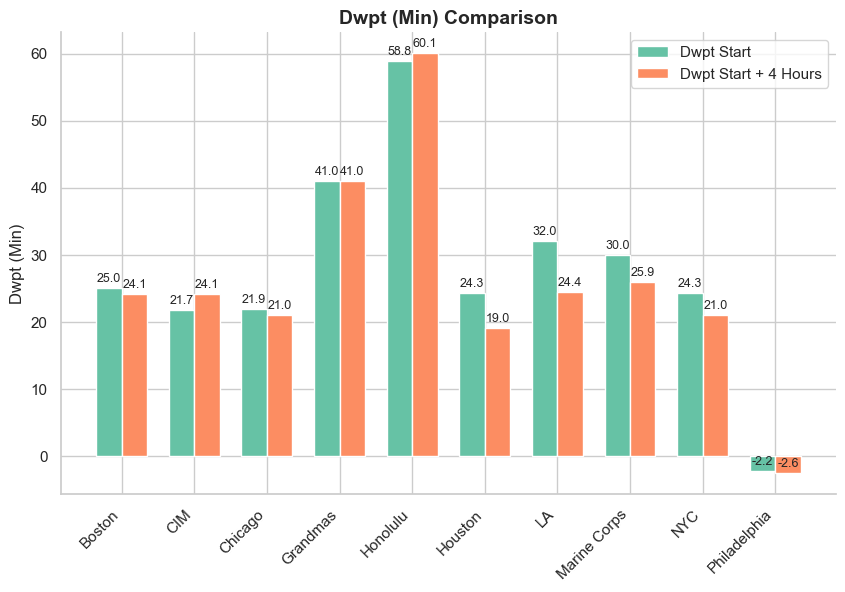

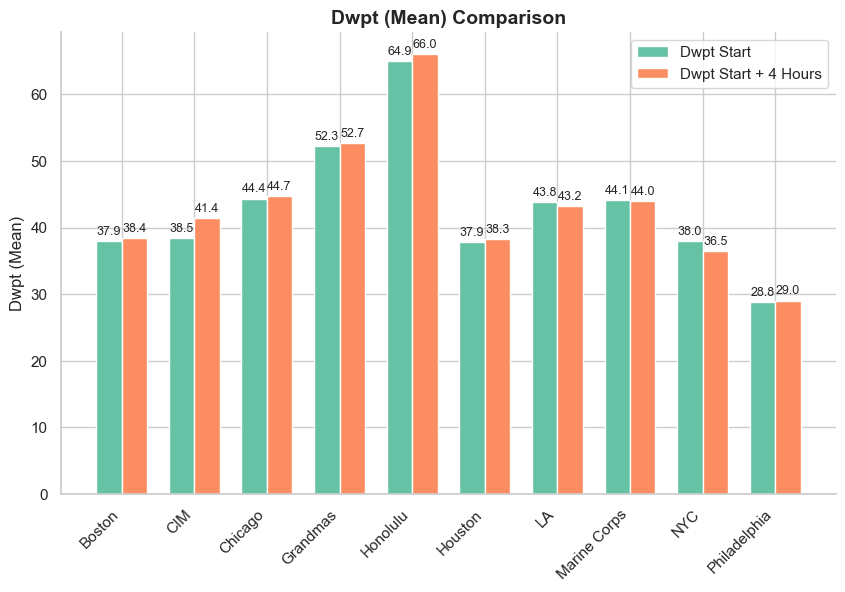

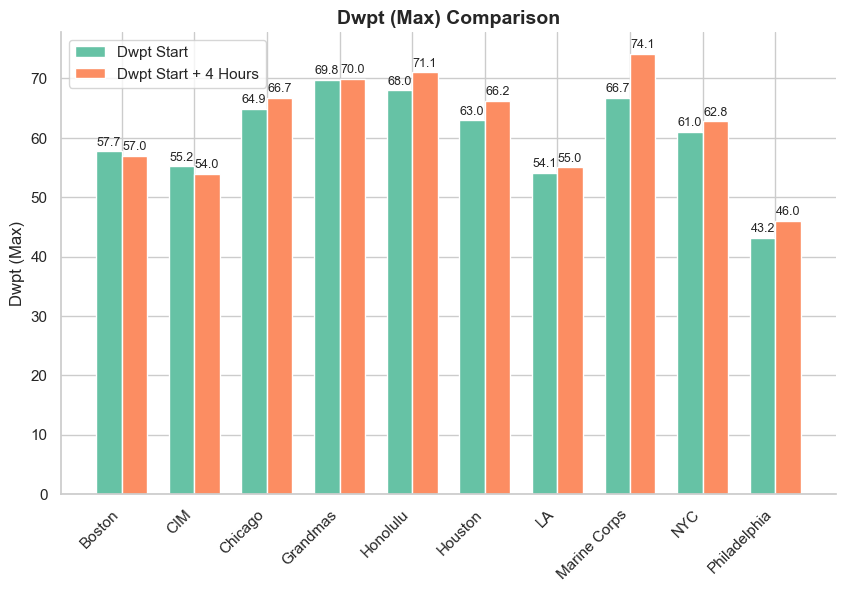

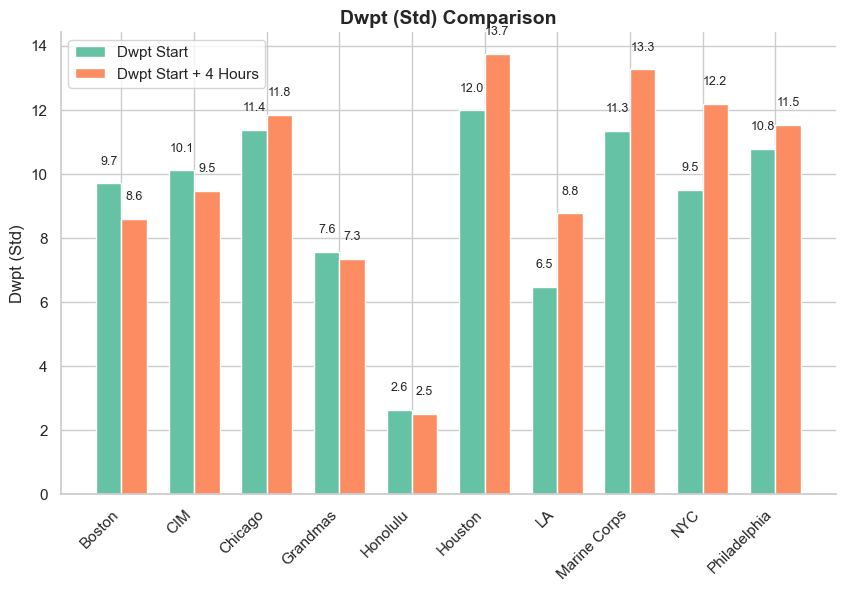

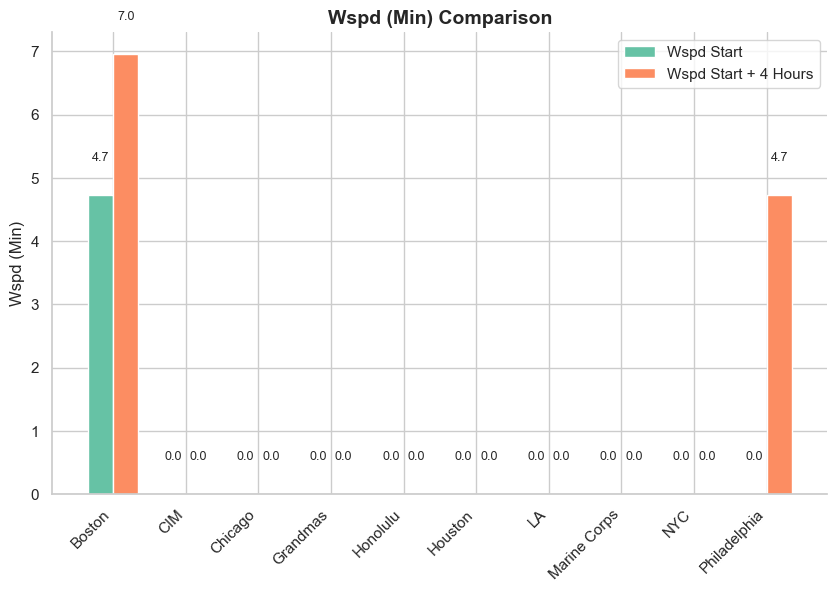

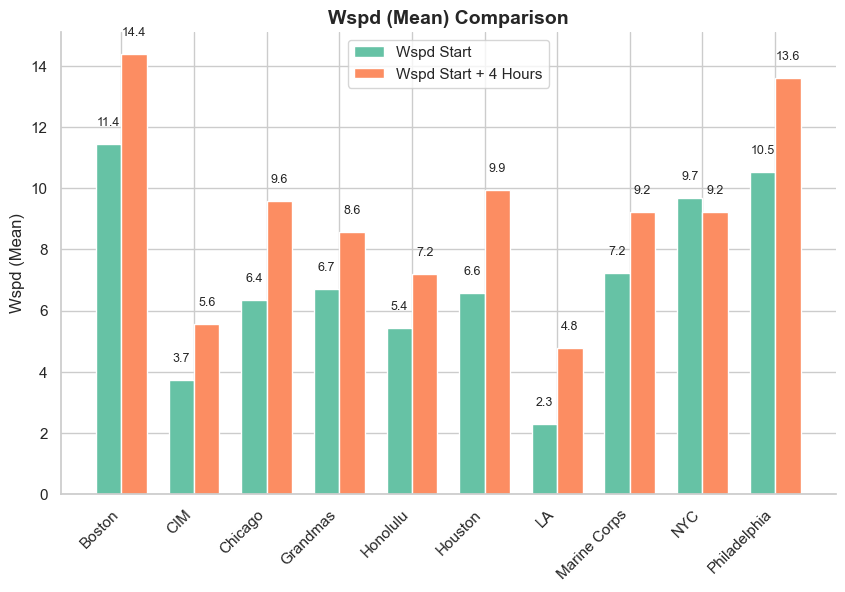

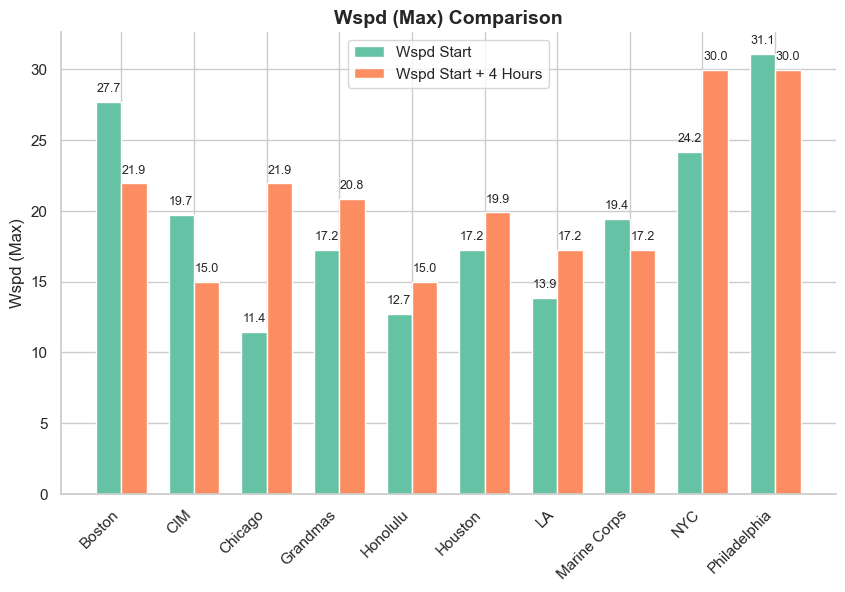

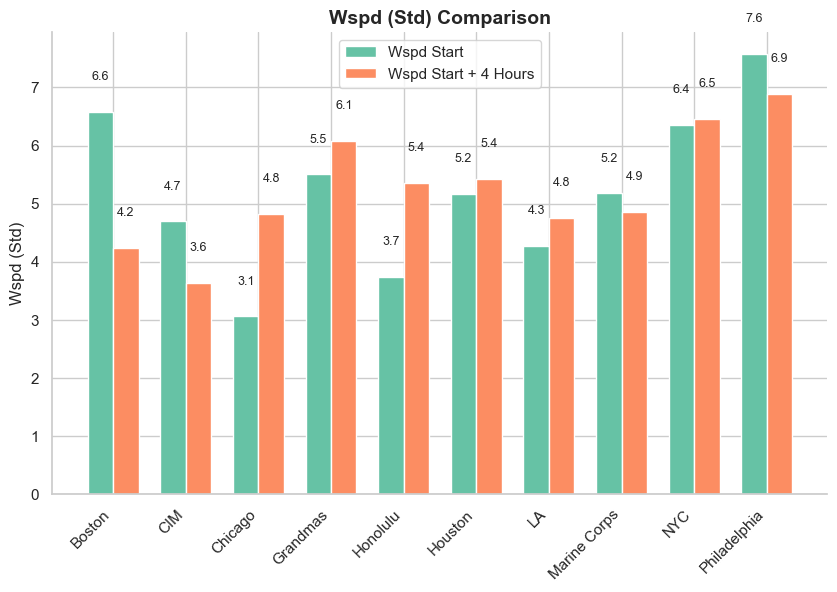

Plots saved to plots_aggregated folder.


In [541]:
plot_and_save_aggregated_metrics(pivot_df)

In [ ]:
print(nyc.head(2))

   local_date  year  temp_start  temp_start_plus_4  rhum_start  \
0  2005-11-06  2005       51.98              64.94        97.0   
1  2006-11-05  2006       42.08              51.08        55.0   

   rhum_start_plus_4  dwpt_start  dwpt_start_plus_4  prcp_start  \
0               70.0       51.08              54.86         0.0   
1               35.0       27.14              24.44         0.0   

   prcp_start_plus_4  wspd_start  wspd_start_plus_4 local_time_start  \
0                0.0    5.840887           6.959355         09:00:00   
1                0.0    0.000000           6.959355         09:00:00   

  local_time_start_plus_4 marathon_name  
0                13:00:00           NYC  
1                13:00:00           NYC  


In [ ]:
nyc_agg

,index,year,temp_start,temp_start_plus_4,rhum_start,rhum_start_plus_4,dwpt_start,dwpt_start_plus_4,prcp_start,prcp_start_plus_4,wspd_start,wspd_start_plus_4,marathon_name
0,mean,2014.5,50.549,56.876,62.55,48.35,37.994,36.545,0.0,0.068421,9.668533,9.211825,NYC
1,min,2005.0,42.080,48.020,49.00,29.00,24.260,21.020,0.0,0.000000,0.000000,0.000000,NYC
2,max,2024.0,68.540,73.220,97.00,90.00,60.980,62.780,0.0,0.800000,24.171332,29.950082,NYC


In [554]:
pivot_df[('temp_start','max')], pivot_df[('temp_start','min')]

(marathon_name
 Boston          73.94
 CIM             59.00
 Chicago         73.04
 Grandmas        71.60
 Honolulu        75.02
 Houston         64.04
 LA              69.98
 Marine Corps    68.00
 NYC             68.54
 Philadelphia    53.96
 Name: (temp_start, max), dtype: float64,
 marathon_name
 Boston          39.92
 CIM             28.94
 Chicago         30.92
 Grandmas        44.60
 Honolulu        66.92
 Houston         28.94
 LA              46.40
 Marine Corps    37.04
 NYC             42.08
 Philadelphia    24.98
 Name: (temp_start, min), dtype: float64)

In [552]:
pivot_df[('temp_start','max')] - pivot_df[('temp_start','min')]

marathon_name
Boston          34.02
CIM             30.06
Chicago         42.12
Grandmas        27.00
Honolulu         8.10
Houston         35.10
LA              23.58
Marine Corps    30.96
NYC             26.46
Philadelphia    28.98
dtype: float64

In [558]:
marine_corps[['year','prcp_start','prcp_start_plus_4']]

,year,prcp_start,prcp_start_plus_4
0,2005,0.0,0.0
1,2006,0.0,0.0
2,2007,0.0,0.0
3,2008,0.0,0.0
4,2009,0.0,0.0
5,2010,0.0,0.0
6,2011,0.0,0.0
7,2012,NaN,0.0
8,2013,0.0,0.0
9,2014,0.0,0.0


In [553]:
pivot_df[('temp_start_plus_4','max')], pivot_df[('temp_start_plus_4','min')]

(marathon_name
 Boston          78.98
 CIM             62.06
 Chicago         82.04
 Grandmas        78.80
 Honolulu        80.96
 Houston         73.04
 LA              84.02
 Marine Corps    75.92
 NYC             73.22
 Philadelphia    59.00
 Name: (temp_start_plus_4, max), dtype: float64,
 marathon_name
 Boston          44.06
 CIM             37.04
 Chicago         37.94
 Grandmas        46.40
 Honolulu        71.96
 Houston         41.00
 LA              51.80
 Marine Corps    48.02
 NYC             48.02
 Philadelphia    28.94
 Name: (temp_start_plus_4, min), dtype: float64)

In [551]:
pivot_df[('dwpt_start_plus_4','max')] - pivot_df[('dwpt_start_plus_4','min')]

marathon_name
Boston          32.94
CIM             29.88
Chicago         45.72
Grandmas        28.98
Honolulu        10.98
Houston         47.16
LA              30.60
Marine Corps    48.24
NYC             41.76
Philadelphia    48.60
dtype: float64